<a href="https://colab.research.google.com/github/unipd-human-data/env-soundnet/blob/main/step-forward.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocessing

Installazione librerie e setup ambiente

In [1]:
!pip install librosa pydub torchaudio snntorch tqdm matplotlib seaborn torchinfo

In [2]:
# Libreria standard
import os                               # file e cartelle
import numpy as np                      # operazioni matriciali, audio e spet sono matrici
import pandas as pd                     # leggere e gestire tabelle come esc50.csv
import matplotlib.pyplot as plt         # grafici std
import seaborn as sns                   # grafici statistici più belli

# Audio
import librosa                          # per audio in python, calcola features ecc
import librosa.display                  # visualizzare spettrogrammi
import torchaudio                       # audio di pytorch, usata per pipeline integrata con PyTorch
import torchaudio.transforms as T       # Moduli per convertire audio in MelSpectogram o trasfromazioni
from pydub import AudioSegment          # gestire audio a livello più "umano"

# Deep learning e SNN
import torch                            # costruzioni reti neurali
import snntorch as snn                  # estensione pytorch per SNN
import snntorch.functional as SF
from snntorch import spikegen           # converte input in spike train
from snntorch import spikeplot as splt
import tensorflow as tf                 # costruzione e training di modelli di ml e dl
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from torchinfo import summary

# Altri
from tqdm import tqdm                   # aggiungere barre di progresso ai loop, quanto manca al caricamento audio
from torch.utils.data import Dataset    # Dataset class
from torch.utils.data import DataLoader # DataLoader class
from enum import Enum
import time


In [3]:
print("GPU disponibile:", tf.config.list_physical_devices('GPU'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Userai:", device)

GPU disponibile: []
Userai: cpu


Collegamento al drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Uploading CSV of ESC-50 metadata. Relocation of audio files in the ESC-50 and ESC-10 folders

In [5]:
esc_50_df = pd.read_csv("/content/drive/MyDrive/HumanData/ESC-50-master/meta/esc50.csv")

def relocate_files(file_name, category, is_esc10):
  src = f"/content/drive/MyDrive/HumanData/ESC-50-master/audio/{file_name}"
  esc50_dest_folder = f"/content/drive/MyDrive/HumanData/ESC-50/{category}"
  esc10_dest_folder = f"/content/drive/MyDrive/HumanData/ESC-10/{category}"

  # Ensure destination folder exists, creation folders
  os.makedirs(esc50_dest_folder, exist_ok=True)
  if is_esc10:
    os.makedirs(esc10_dest_folder, exist_ok=True)

  dest_esc50 = os.path.join(esc50_dest_folder, file_name)
  dest_esc10 = os.path.join(esc10_dest_folder, file_name)

  # Check if the file already exists in the destination
  if not os.path.exists(dest_esc50):
    shutil.copy(src, dest_esc50)
    print(f"Moved {file_name} to {dest_esc50}")
  else:
    print(f"File '{file_name}' already exists in '{dest_esc50}', skipping...")

  if not os.path.exists(dest_esc10):
    if is_esc10:
      shutil.copy(src, dest_esc10)
      print(f"Moved {file_name} to {dest_esc10}")
  else:
    print(f"File '{file_name}' already exists in '{dest_esc10}', skipping...")


#esc_50_df.apply(lambda row: relocate_files(row['filename'], row['category'], row['esc10']), axis = 1)


In [6]:
%ls /content/drive/MyDrive/HumanData/ESC-10/


chainsaw/    crackling_fire/  dog/         rain/     sea_waves/
clock_tick/  crying_baby/     helicopter/  rooster/  sneezing/


## Processare tutti i file audio di ESC10

In [7]:
BASE_PATH = '/content/drive/MyDrive/HumanData/ESC-10'
SAMPLE_RATE = 44100  # non fare downsampling
N_MELS = 128
N_FFT = 1024
HOP_LENGTH = 512
DURATION = 5.0       # lunghezza standard (secondi)
BATCH_SIZE = 32

class ESCLabels(Enum):
    chainsaw = 0
    clock_tick = 1
    crackling_fire = 2
    crying_baby = 3
    dog = 4
    helicopter = 5
    rain = 6
    rooster = 7
    sea_waves = 8
    sneezing = 9

- Se un audio ha una frequenza di campionamento di 44.1 kHz, significa che ogni secondo è rappresentato da 44.100 campioni (numeri). Più alta è la frequenza, più dettagliato sarà il suono (fino a un certo limite). 44.1 kHz è sufficiente per rappresentare tutte le frequenze udibili dall’orecchio umano (fino a ~20 kHz), secondo il teorema di Nyquist.

- Trim + Normalizzazione: rimuovo silenzio per non sprecare tempo computazionale su dati inutili. Scalare il segnale in [-1,1] in modo da rimuovere il bias di ampiezza tra clip (evita che la rete impari "volume=classe")

- Con la normalizzazione vado a modificare il range dell'ampiezza, cioè quanto forte o debole è il segnale

per ora non trimmo i silenzio --> possibile ablation study con e senza trim

Perché NON usare trim:
Mantieni la coerenza temporale tra le clip
→ fondamentale per SNN e spike encoding, che sono sensibili alla sequenza temporale dei pattern.

Eviti disallineamenti introdotti da librosa.effects.trim
→ anche 0.2 secondi di shift possono alterare l’input percepito dal modello.

Se usi segmenti (chunk) fissi via timesteps=50,
→ i segmenti devono sempre partire dallo stesso punto temporale.

In [8]:
def load_audio_file(file_path, sr=SAMPLE_RATE, duration=5.0, top_db = 30):
    y, sr = librosa.load(file_path, sr=sr, duration=duration)
    #y, _ = librosa.effects.trim(y, top_db=top_db)           # elimina silence iniziale e finale
    y = librosa.util.normalize(y)           # normalizzazione RMS
    #if len(y) < int(sr * duration):
    #    padding = int(sr * duration) - len(y)
    #    y = np.pad(y, (0, padding))         # padding se troppo corto
    return y

controllo di quanto silenzio toglie

In [9]:
# total_trimmed_start = 0.0
# total_trimmed_end = 0.0
# clip_count = 0

# for label in sorted(os.listdir(BASE_PATH)):
#     class_path = os.path.join(BASE_PATH, label)
#     for file in os.listdir(class_path):
#         if file.endswith(".wav"):
#             file_path = os.path.join(class_path, file)

#             # Carica audio
#             y, sr = librosa.load(file_path, sr=44100, duration=5.0)

#             # Applica trim
#             y_trimmed, index = librosa.effects.trim(y, top_db=30)
#             start_sample, end_sample = index

#             # Converti in secondi
#             start_sec = start_sample / sr
#             end_sec = (len(y) - end_sample) / sr

#             total_trimmed_start += start_sec
#             total_trimmed_end += end_sec
#             clip_count += 1

#             print(f"{file} → Trim: start={start_sec:.2f}s, end={end_sec:.2f}s")

# # Statistiche finali
# print("\n--- STATISTICHE TOTALI ---")
# print(f"Clip analizzati: {clip_count}")
# print(f"Silenzio medio INIZIALE tagliato: {total_trimmed_start / clip_count:.2f} s")
# print(f"Silenzio medio FINALE tagliato: {total_trimmed_end / clip_count:.2f} s")


In [10]:
X_audio = []
y_labels = []
labels = sorted(os.listdir(BASE_PATH))  # lista classi ordinate
print(labels, "\n")
label_to_index = {label: idx for idx, label in enumerate(labels)}

for label in tqdm(labels, desc="Caricamento Audio"):
    class_path = os.path.join(BASE_PATH, label)
    for file in os.listdir(class_path):
        if file.endswith('.wav'):
            file_path = os.path.join(class_path, file)
            y = load_audio_file(file_path, sr=SAMPLE_RATE, duration=DURATION)
            X_audio.append(y)
            y_labels.append(label_to_index[label])

['chainsaw', 'clock_tick', 'crackling_fire', 'crying_baby', 'dog', 'helicopter', 'rain', 'rooster', 'sea_waves', 'sneezing'] 



Caricamento Audio: 100%|██████████| 10/10 [00:09<00:00,  1.11it/s]


In [11]:
X_train, X_temp, y_train, y_temp = train_test_split(X_audio, y_labels, test_size=0.4, random_state=42, stratify=y_labels)

# Poi dividi temp in val e test (50/50 => 15% ciascuno)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

Train: 240, Val: 80, Test: 80


## NAA

In [12]:
def center_crop(signal, target_len):
    if len(signal) < target_len:
        pad_left = (target_len - len(signal)) // 2
        pad_right = target_len - len(signal) - pad_left
        return np.pad(signal, (pad_left, pad_right), mode='constant')
    else:
        start = (len(signal) - target_len) // 2
        return signal[start:start + target_len]

In [13]:
def naa(y, sr):
    augmented = []
    target_len = int(sr * 5.0)

    # Originale
    augmented.append(center_crop(y, target_len))

    # Pitch shift
    augmented.append(center_crop(librosa.effects.pitch_shift(y, sr=sr, n_steps=+2), target_len))
    augmented.append(center_crop(librosa.effects.pitch_shift(y, sr=sr, n_steps=-2), target_len))

    # Time stretch
    for rate in [0.7, 1.2]:
        y_stretched = librosa.effects.time_stretch(y, rate=rate)
        augmented.append(center_crop(y_stretched, target_len))

    return augmented

In [14]:

X_train_aug = []
y_train_aug = []

for i in tqdm(range(len(X_train)), desc="NAA"):
    original_audio = X_train[i]
    label = y_train[i]

    # Applica la tua funzione naa → restituisce 5 versioni (incluso l'originale)
    augmented_audios = naa(original_audio, sr=SAMPLE_RATE)

    # Aggiungi tutte le versioni alla lista finale
    X_train_aug.extend(augmented_audios)
    y_train_aug.extend([label] * len(augmented_audios))

NAA: 100%|██████████| 240/240 [02:19<00:00,  1.72it/s]


In [15]:

# Calcola le lunghezze di tutti gli audio
lengths = [len(x) for x in X_train_aug]

# Trova il minimo e il massimo
min_len = min(lengths)
max_len = max(lengths)

# Converti in secondi (facoltativo)
min_sec = min_len / SAMPLE_RATE
max_sec = max_len / SAMPLE_RATE

print(f"Audio più corto: {min_len} samples ({min_sec:.2f} s)")
print(f"Audio più lungo: {max_len} samples ({max_sec:.2f} s)")

Audio più corto: 220500 samples (5.00 s)
Audio più lungo: 220500 samples (5.00 s)


## Converti in log-Mel

- power_to_db(..., ref=np.max) normalizza ogni spettrogramma rispetto al suo massimo → rende il contrasto tra le bande più utile per la rete. Misura quanto ogni frequenza è forte rispetto al picco. Ha senso np.max perchè ho già normalizzato l'audio a [-1,1] quindi non hai una loudness assoluta. Per la classificazione di suoni ambientali il pattern spettrale è più importante del volume, voglio che ogni clip sia trattato in modo coerente (garantisce scale relative)

- power_to_db(..., ref=np.max) converte il Mel-spectrogramma da potenza lineare (espressa in unità numeriche) a decibel (scala logaritmica)

- il risultato più intenso avrà valore 0 dB. -80 invece significa “tutto ciò che è almeno 10⁸ volte più debole del valore massimo, consideralo praticamente silenzio”. La scala è negativa perchè stai calcolando il logaritmo del rapporto tra ogni valore del Mel-spect e il valore massimo di quel mel-spect



In [16]:
def preprocess_audio(y, sr=SAMPLE_RATE, n_mels=N_MELS, n_fft=N_FFT, hop_length=HOP_LENGTH):
  #Calcolare Mel-spectrogram
  y_mel = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
  #Convertire in Log
  y_mel = librosa.power_to_db(y_mel, ref=np.max)    #calcola i db rispetto al valore massimo nel Mel-spect.

  return y_mel


Clipping dei frame troppo silenziosi

In [17]:
def clip_silent_frames(mel, threshold_db=-70.0):
    silent_mask = np.all(mel < threshold_db, axis=0)
    mel[:, silent_mask] = threshold_db  # o np.mean(mel)
    return mel

In [18]:
def batch_logmel(X, sr=SAMPLE_RATE):
    mel_list = []
    for x in tqdm(X, desc="Log-Mel"):
        mel = preprocess_audio(x, sr=sr)
        # mel = clip_silent_frames(mel)
        mel_list.append(mel)
    return mel_list

In [19]:

X_train_mel = batch_logmel(X_train_aug)
X_val_mel = batch_logmel(X_val)
X_test_mel = batch_logmel(X_test)

"""
X_train_mel = batch_logmel(X_train)
X_val_mel = batch_logmel(X_val)
X_test_mel = batch_logmel(X_test)
"""

Log-Mel: 100%|██████████| 80/80 [00:01<00:00, 75.43it/s]


'\nX_train_mel = batch_logmel(X_train)\nX_val_mel = batch_logmel(X_val)\nX_test_mel = batch_logmel(X_test)\n'

In [20]:
print("Train set:", len(X_train_mel))
print("Val set:", len(X_val_mel))
print("Test set:", len(X_test_mel))

print("Shape primo sample train:", X_train_mel[0].shape)

Train set: 1200
Val set: 80
Test set: 80
Shape primo sample train: (128, 431)


visualizzo logmel spect

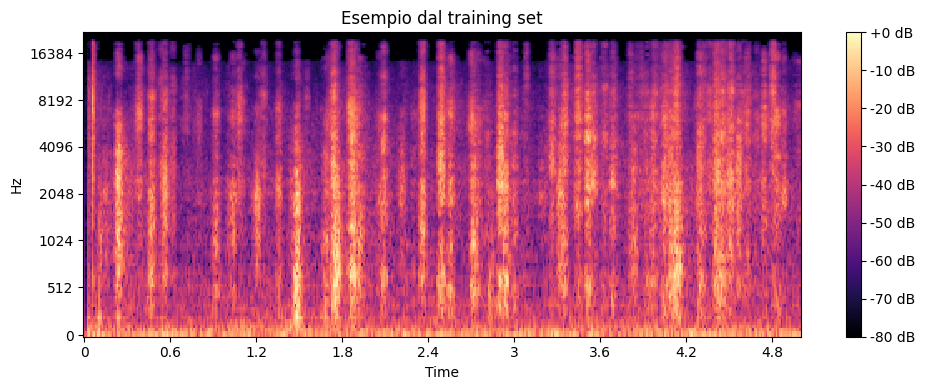

Class:  sea_waves


In [21]:
def show_mel(mel, title="Log-Mel Spectrogram"):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel, sr=SAMPLE_RATE, hop_length=HOP_LENGTH, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Visualizza un esempio a caso dal training set
sample_idx = 32
show_mel(X_train_mel[sample_idx], title="Esempio dal training set")
print("Class: ", ESCLabels(y_train[sample_idx]).name)


In [22]:
all_vals = np.concatenate([mel.flatten() for mel in X_train_mel])
print("Min:", np.min(all_vals))
print("Max:", np.max(all_vals))

Min: -80.0
Max: 0.0


Padding per uniformare a 450

In [23]:
def pad_to_multiple_of(mel, multiple=50, value=-80.0):
    # Pads mel spectrogram along time axis to make time frames a multiple of 'multiple'
    current_len = mel.shape[1]
    target_len = ((current_len + multiple - 1) // multiple) * multiple
    pad_width = target_len - current_len
    return np.pad(mel, ((0, 0), (0, pad_width)), mode='constant', constant_values=value)

In [24]:
# Applica padding a multiplo di 50 (compatibile con timesteps=50)
X_train_mel = [pad_to_multiple_of(mel, multiple=50) for mel in X_train_mel]
X_val_mel = [pad_to_multiple_of(mel, multiple=50) for mel in X_val_mel]
X_test_mel = [pad_to_multiple_of(mel, multiple=50) for mel in X_test_mel]

In [25]:
print("Train shape esempio:", X_train_mel[0].shape)
print("Val shape esempio:", X_val_mel[0].shape)
print("Test shape esempio:", X_test_mel[0].shape)

Train shape esempio: (128, 450)
Val shape esempio: (128, 450)
Test shape esempio: (128, 450)


## DATA AUG TAA

applicare taa dopo normalizzazione perchè imagedatagenerator lavora bene su [0,1]

In [26]:
"""
taa_generator = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.25,
    shear_range=0.3,
    fill_mode='nearest'
)
"""

"\ntaa_generator = ImageDataGenerator(\n    width_shift_range=0.2,\n    height_shift_range=0.2,\n    zoom_range=0.25,\n    shear_range=0.3,\n    fill_mode='nearest'\n)\n"

In [27]:
X_train_mel_np = np.array(X_train_mel)
X_val_mel_np = np.array(X_val_mel)
X_test_mel_np = np.array(X_test_mel)

if len(X_train_mel_np.shape) == 3:
    X_train_mel_np = X_train_mel_np[..., np.newaxis]  # (N, 64, 431, 1)

y_train_np = np.array(y_train_aug)  # Etichette corrispondenti
# y_train_np = np.array(y_train)

### Normalizzazione:
i modelli funzionano meglio con input compresi tra 0 e 1.
0 = silenzio
1 = banda più forte

In [28]:
X_train_mel_np = (X_train_mel_np + 80.0) / 80.0
X_val_mel_np = (X_val_mel_np + 80.0) / 80.0
X_test_mel_np = (X_test_mel_np + 80.0) / 80.0

### TAA

In [29]:
"""
X_taa = []
y_taa = []

augmentations_per_sample = 4  # puoi aumentare questo numero

for i in tqdm(range(len(X_train_mel_np)), desc="TAA Augmentation"):
    sample = X_train_mel_np[i]  # shape: (64, max_len, 1)
    sample = np.expand_dims(sample, axis=0)  # shape: (1, 64, max_len, 1)

    # Genera augmentazioni
    gen = taa_generator.flow(sample, batch_size=1)
    for _ in range(augmentations_per_sample):
        aug_sample = next(gen)[0]  # shape: (64, max_len, 1)
        X_taa.append(aug_sample)
        y_taa.append(y_train_np[i])

# Combina con il training set originale
X_train_augmented = np.concatenate([X_train_mel_np, np.array(X_taa)], axis=0)
y_train_augmented = np.concatenate([y_train_np, np.array(y_taa)], axis=0)

print("Nuova shape X:", X_train_augmented.shape)
print("Nuova shape y:", y_train_augmented.shape)
"""

'\nX_taa = []\ny_taa = []\n\naugmentations_per_sample = 4  # puoi aumentare questo numero\n\nfor i in tqdm(range(len(X_train_mel_np)), desc="TAA Augmentation"):\n    sample = X_train_mel_np[i]  # shape: (64, max_len, 1)\n    sample = np.expand_dims(sample, axis=0)  # shape: (1, 64, max_len, 1)\n\n    # Genera augmentazioni\n    gen = taa_generator.flow(sample, batch_size=1)\n    for _ in range(augmentations_per_sample):\n        aug_sample = next(gen)[0]  # shape: (64, max_len, 1)\n        X_taa.append(aug_sample)\n        y_taa.append(y_train_np[i])\n\n# Combina con il training set originale\nX_train_augmented = np.concatenate([X_train_mel_np, np.array(X_taa)], axis=0)\ny_train_augmented = np.concatenate([y_train_np, np.array(y_taa)], axis=0)\n\nprint("Nuova shape X:", X_train_augmented.shape)\nprint("Nuova shape y:", y_train_augmented.shape)\n'

Converto in tensori

In [30]:
"""
X_train = torch.from_numpy(X_train_augmented).float()
X_val = torch.from_numpy(X_val_mel_np).float()
X_test = torch.from_numpy(X_test_mel_np).float()
y_train = torch.from_numpy(y_train_augmented).long()
y_val = torch.from_numpy(np.array(y_val)).long()
y_test = torch.from_numpy(np.array(y_test)).long()
"""

X_train = torch.from_numpy(X_train_mel_np).float()
X_val = torch.from_numpy(X_val_mel_np).float()
X_test = torch.from_numpy(X_test_mel_np).float()
y_train = torch.from_numpy(y_train_np).long()
y_val = torch.from_numpy(np.array(y_val)).long()
y_test = torch.from_numpy(np.array(y_test)).long()

In [31]:
print("Shape X_train:", X_train.shape)
print("Tipo dati:", X_train.dtype)
print("Valori min/max:", torch.min(X_train), torch.max(X_train))


Shape X_train: torch.Size([1200, 128, 450, 1])
Tipo dati: torch.float32
Valori min/max: tensor(0.) tensor(1.)


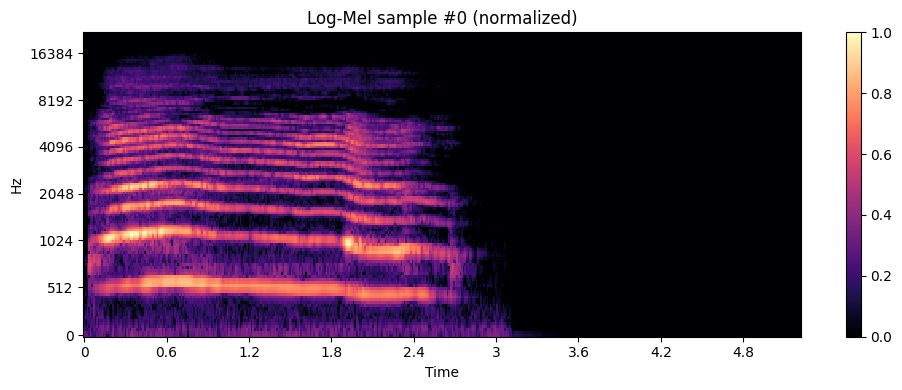

Class: crying_baby


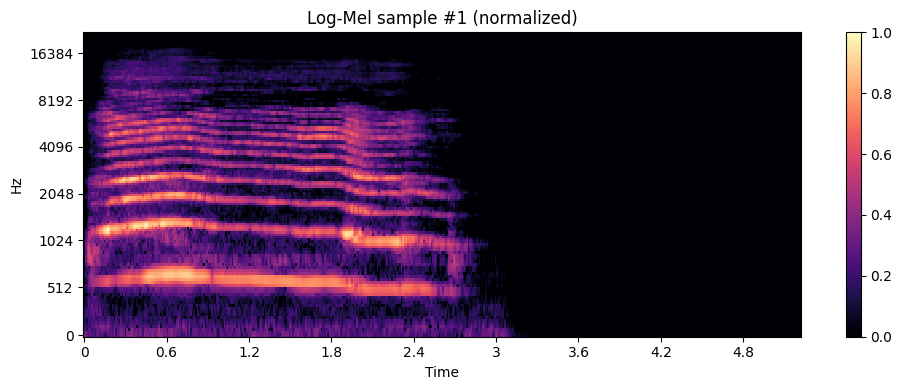

Class: crying_baby


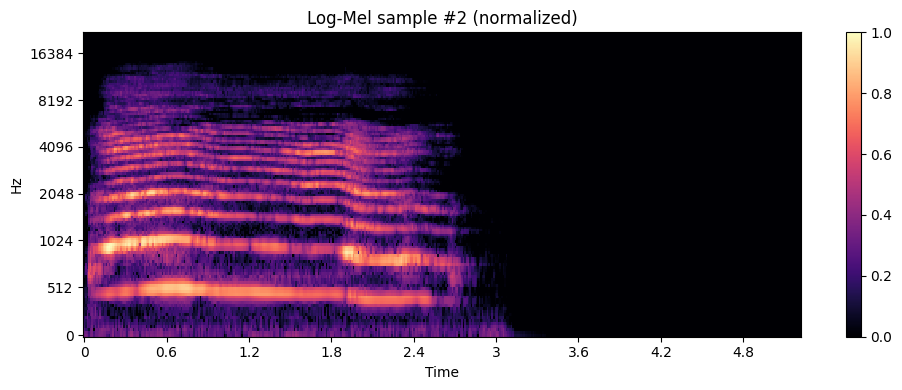

Class: crying_baby


In [32]:
def show_mel_sample(index):
    mel = X_train[index].numpy().squeeze()  # converti tensore in NumPy
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel, sr=SAMPLE_RATE, hop_length=HOP_LENGTH, x_axis='time', y_axis='mel')
    plt.colorbar()  # non usare '%+2.0f dB' perché ora i valori sono [0, 1]
    plt.title(f"Log-Mel sample #{index} (normalized)")
    plt.tight_layout()
    plt.show()
    print("Class:", ESCLabels(y_train[index].item()).name)

for i in range(3):
    show_mel_sample(i)

In [33]:
print("y_train shape:", y_train.shape)
print("Etichette uniche:", np.unique(y_train))

# Stampa etichetta di un esempio
for i in range(3):
    print(f"Esempio {i}: label = {y_train[i]}")


y_train shape: torch.Size([1200])
Etichette uniche: [0 1 2 3 4 5 6 7 8 9]
Esempio 0: label = 3
Esempio 1: label = 3
Esempio 2: label = 3


# Spike Encoding

We define now an helper function to visualize the following ecoded spike trains.

In [34]:
def visualize_spike_trains(spike_tensor, sample_idx=0, mel_bin=10):
    """
    Visualizes delta spike encodings with three plots:
    1. Full raster plot of all mel bins
    2. Single mel bin spike train with vertical lines
    3. Density plot showing balance between positive and negative spikes

    Args:
      spike_tensor : torch.Tensor or list
          The delta spike tensor. Expected shape: [batch_size, time_frames, n_mels]
          If from DataLoader, expected to be a list containing tensors
      sample_idx : int
          Index of the sample in the batch to visualize
      mel_bin : int
          Which mel frequency bin to visualize in the spike train plot
    """

    # Check if input is a list (from DataLoader) or direct tensor
    if isinstance(spike_tensor, list):
        spikes = spike_tensor[0].squeeze(-1)[sample_idx].detach().cpu().numpy()
    elif isinstance(spike_tensor, torch.Tensor):
        # If 4D tensor [batch_size, time_frames, n_mels]
        if len(spike_tensor.shape) == 3:
            spikes = spike_tensor.squeeze(-1)[sample_idx, :, :].detach().cpu().numpy()
        else:
            raise ValueError(f"Unexpected spike tensor shape: {spike_tensor.shape}")
    else:
        raise TypeError("spike_tensor must be a torch.Tensor or a list containing tensors")

    if len(spikes.shape) > 2:
        spikes = spikes.squeeze()

    pos_spikes = (spikes > 0).astype(float)
    neg_spikes = (spikes < 0).astype(float)

    plt.figure(figsize=(10, 12))

    # 1. Raster Plot with Inverted Y-axis
    plt.subplot(3, 1, 1)
    plt.imshow(spikes.T, aspect='auto', cmap='coolwarm', vmin=-1, vmax=1, origin='lower')
    plt.colorbar(ticks=[-1, 0, 1], label='Spike Type')
    plt.title("Full Raster Plot")
    plt.xlabel("Time Step")
    plt.ylabel("Mel Bin")
    num_mel_bins = spikes.shape[1]
    tick_interval = max(1, num_mel_bins // 7)
    plt.yticks(np.arange(0, num_mel_bins, tick_interval))

    # 2. Single Mel Bin Spike Train with vlines
    plt.subplot(3, 1, 2)
    pos_times = np.where(spikes[:, mel_bin] == 1)[0]
    neg_times = np.where(spikes[:, mel_bin] == -1)[0]
    plt.vlines(pos_times, 0, 1, color='red', linewidth=0.8)
    plt.vlines(neg_times, -1, 0, color='blue', linewidth=0.8)
    plt.yticks([-1, 0, 1])
    plt.ylim(-1.2, 1.2)
    plt.title(f"Spike Train for Mel Bin {mel_bin}")
    plt.xlabel("Time Step")
    plt.ylabel("Spike Value")
    plt.grid(False)
    legend_elements = [plt.Line2D([0], [0], color='red', lw=2, label='Positive Spikes'),
                      plt.Line2D([0], [0], color='blue', lw=2, label='Negative Spikes')]
    plt.legend(handles=legend_elements)

    # 3. Density Plot with Legend
    plt.subplot(3, 1, 3)
    plt.stackplot(np.arange(spikes.shape[0]),
                  pos_spikes.sum(axis=1),
                  -neg_spikes.sum(axis=1),
                  colors=['red', 'blue'])

    plt.legend(['Positive Spikes', 'Negative Spikes'])
    plt.title("Spike Polarity Balance Over Time")
    plt.xlabel("Time Step")
    plt.ylabel("Net Spike Count")

    plt.tight_layout()
    plt.show()

## Step Forward

In [35]:
class StepForwardDataset(Dataset):

  """
  Dataset class that applies Step Forward encoding to spectrograms.
  """
  def __init__(self, X, y, threshold=0.05):
    """
    Args:
      X: Tensor of shape [num_samples, n_mels, time_steps, 1]
      y: Tensor of labels [num_samples]
      threshold: Threshold for Step Forward encoding
    """
    self.X = X
    self.y = y
    self.threshold = threshold

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    x = self.X[idx].squeeze(-1)  # [n_mels, time_steps]
    y = self.y[idx]

    spike_train = torch.zeros(
        x.shape[1], x.shape[0], dtype=torch.int8
    )  # [time_steps, n_mels]

    # Apply Step Forward encoding to each mel frequency bin
    for mel_idx in range(x.shape[0]):
        spikes, _ = self._encode(x[mel_idx])
        spike_train[:, mel_idx] = torch.from_numpy(spikes)

    return spike_train, y.long()

  def _encode(self, input_signal):
    """
    Step Forward encoding algorithm implementation.

    Args:
        input_signal: 1D array/tensor - input signal to encode
        threshold: float - threshold value for spike generation

    Returns:
        spikes: 1D array - encoded spike train with values {-1, 0, 1}
        base_history: 1D array - history of base values (for debugging/analysis)
    """
    # Convert to numpy if torch tensor
    if isinstance(input_signal, torch.Tensor):
        input_signal = input_signal.numpy()

    L = len(input_signal)
    spikes = np.zeros(L, dtype=np.int8)
    base_history = np.zeros(L)  # Track base evolution

    # Initialize base with first input value
    base = input_signal[0]
    base_history[0] = base

    # Process each timestep starting from index 1
    for i in range(1, L):
        if input_signal[i] > base + self.threshold:
            spikes[i] = 1
            base = base + self.threshold  # Update base upward
        elif input_signal[i] < base - self.threshold:
            spikes[i] = -1
            base = base - self.threshold  # Update base downward
        # else: spikes[i] remains 0

        base_history[i] = base

    return spikes, base_history


In [36]:
sf_train_dataset = StepForwardDataset(
    X_train, y_train,
    threshold=0.05
)

sf_val_dataset = StepForwardDataset(
    X_val, y_val,
    threshold=0.05
)

sf_test_dataset = StepForwardDataset(
    X_test, y_test,
    threshold=0.05
)

sf_train_dataloader = DataLoader(
    dataset=sf_train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=torch.cuda.is_available()
)

sf_val_dataloader = DataLoader(
    dataset=sf_val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=torch.cuda.is_available()
)

sf_test_dataloader = DataLoader(
    dataset=sf_test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=torch.cuda.is_available()
)


sf_x_batch, sf_y_batch = next(iter(sf_train_dataloader))
print(sf_x_batch.shape)

torch.Size([32, 450, 128])


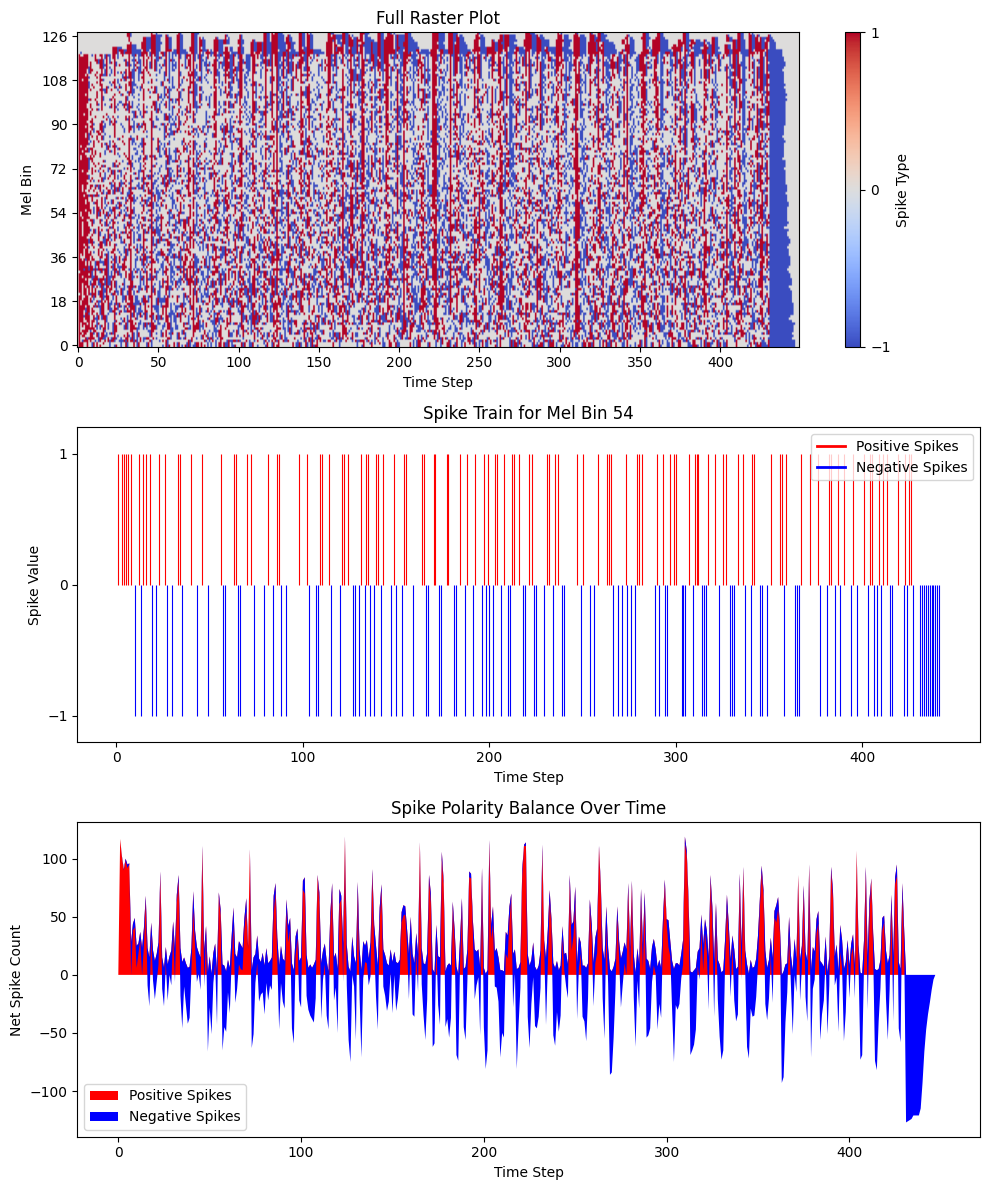

In [37]:
sample_idx = 10
visualize_spike_trains(spike_tensor=sf_x_batch, sample_idx=sample_idx, mel_bin=54)

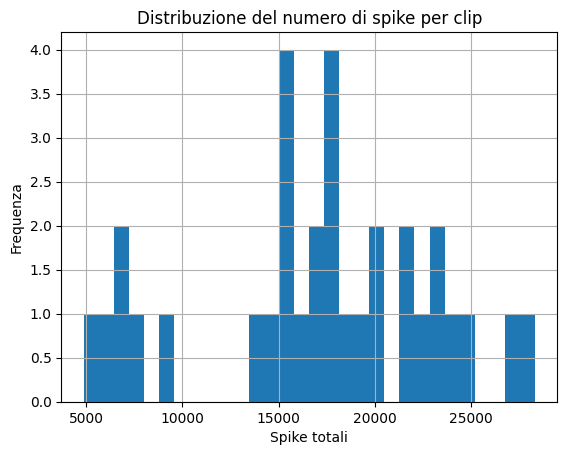

In [38]:
def count_spikes(spike_train):
    return spike_train.abs().sum(dim=[1, 2])  # somma spike su tempo e bande mel

spike_counts = count_spikes(sf_x_batch)
plt.hist(spike_counts.cpu().numpy(), bins=30)
plt.title("Distribuzione del numero di spike per clip")
plt.xlabel("Spike totali")
plt.ylabel("Frequenza")
plt.grid(True)
plt.show()

In [39]:
def count_spikes_batch(data):
    """
    Count positive and negative spikes in a single batch

    Args:
        data: torch.Tensor of shape (batch_size, channels, timesteps) or (batch_size, timesteps)

    Returns:
        dict with spike counts for this batch
    """
    # Convert to numpy if it's a torch tensor
    if isinstance(data, torch.Tensor):
        data = data.numpy()

    # Handle different tensor shapes
    if len(data.shape) == 3:  # (batch_size, channels, timesteps)
        # Flatten across batch and channels, keep timesteps
        flattened = data.reshape(-1, data.shape[-1])
    elif len(data.shape) == 2:  # (batch_size, timesteps)
        flattened = data
    else:
        raise ValueError(f"Unexpected data shape: {data.shape}")

    # Count spikes
    positive_spikes = (flattened > 0).sum()
    negative_spikes = (flattened < 0).sum()
    zero_values = (flattened == 0).sum()
    total_values = flattened.size

    return {
        'positive_spikes': int(positive_spikes),
        'negative_spikes': int(negative_spikes),
        'zero_values': int(zero_values),
        'total_values': int(total_values)
    }

def analyze_complete_dataset(dataloader, dataset_name="Dataset"):
    """
    Analyze spikes across all batches in a dataloader

    Args:
        dataloader: PyTorch DataLoader
        dataset_name: Name for the dataset (for display purposes)

    Returns:
        dict with complete spike analysis
    """
    print(f"Analyzing {dataset_name}...")

    total_positive = 0
    total_negative = 0
    total_zeros = 0
    total_values = 0
    batch_results = []

    # Iterate through all batches
    for batch_idx, (X_batch, y_batch) in enumerate(tqdm(dataloader, desc=f"Processing {dataset_name}")):
        batch_counts = count_spikes_batch(X_batch)

        # Accumulate totals
        total_positive += batch_counts['positive_spikes']
        total_negative += batch_counts['negative_spikes']
        total_zeros += batch_counts['zero_values']
        total_values += batch_counts['total_values']

        # Store batch results
        batch_results.append({
            'batch_idx': batch_idx,
            'batch_size': X_batch.shape[0],
            **batch_counts
        })

    # Calculate overall statistics
    results = {
        'dataset_name': dataset_name,
        'total_batches': len(batch_results),
        'total_samples': sum([br['batch_size'] for br in batch_results]),
        'total_positive_spikes': total_positive,
        'total_negative_spikes': total_negative,
        'total_zero_values': total_zeros,
        'total_values': total_values,
        'positive_ratio': total_positive / total_values if total_values > 0 else 0,
        'negative_ratio': total_negative / total_values if total_values > 0 else 0,
        'zero_ratio': total_zeros / total_values if total_values > 0 else 0,
        'batch_results': batch_results
    }

    return results

def print_dataset_summary(results):
    """Print a summary of the dataset analysis"""
    print(f"\n{results['dataset_name']} Analysis Results:")
    print("=" * 50)
    print(f"Total batches: {results['total_batches']}")
    print(f"Total samples: {results['total_samples']:,}")
    print(f"Total values analyzed: {results['total_values']:,}")
    print()
    print("Spike Counts:")
    print(f"  Positive spikes: {results['total_positive_spikes']:,}")
    print(f"  Negative spikes: {results['total_negative_spikes']:,}")
    print(f"  Zero values: {results['total_zero_values']:,}")
    print()
    print("Spike Ratios:")
    print(f"  Positive spike ratio: {results['positive_ratio']:.4f} ({results['positive_ratio']*100:.2f}%)")
    print(f"  Negative spike ratio: {results['negative_ratio']:.4f} ({results['negative_ratio']*100:.2f}%)")
    print(f"  Zero ratio: {results['zero_ratio']:.4f} ({results['zero_ratio']*100:.2f}%)")
    print()
    print(f"  Spike density: {(results['total_positive_spikes'] + results['total_negative_spikes']) / results['total_values']:.4f}")


results = analyze_complete_dataset(sf_train_dataloader, dataset_name="StepForward Train")
print_dataset_summary(results)

Analyzing StepForward Train...


Processing StepForward Train: 100%|██████████| 38/38 [01:03<00:00,  1.66s/it]


StepForward Train Analysis Results:
Total batches: 38
Total samples: 1,200
Total values analyzed: 69,120,000

Spike Counts:
  Positive spikes: 9,708,501
  Negative spikes: 10,409,312
  Zero values: 49,002,187

Spike Ratios:
  Positive spike ratio: 0.1405 (14.05%)
  Negative spike ratio: 0.1506 (15.06%)
  Zero ratio: 0.7089 (70.89%)

  Spike density: 0.2911


# SNN Modelling

A single batch of data has shape: \[batch_size, time_frames, n_mels\].

In [40]:
def train_fn(model, train_loader, valid_loader, accuracy, loss_fn, optimizer,
             epochs, patience, path, verbose=True, max_batches=None):
    """
    Optimized training function with:
    - Mixed precision training
    - Reduced GPU memory usage
    - Progress tracking
    """
    train_loss_list, val_loss_list = [], []
    train_acc_list, val_acc_list = [], []
    counter = 0
    best_val_loss = float('inf')

    # Enable mixed precision training if available
    scaler = torch.amp.GradScaler() if torch.cuda.is_available() else None

    for epoch in tqdm(range(epochs), desc="Epochs"):
        start_time = time.time()

        # Training mode
        model.train()
        train_loss, train_acc = 0.0, 0.0

        for batch_idx, (X, y) in enumerate(tqdm(train_loader, desc="Train batches", leave=False, total=len(train_loader))):
            X = X.squeeze().to(device)
            y = y.squeeze().long().to(device)

            optimizer.zero_grad(set_to_none=True)

            # Use mixed precision where available
            if scaler:
                with torch.cuda.amp.autocast():
                    spk_out, _ = model(X.float())
                    acc = accuracy(spk_out, y)
                    loss = loss_fn(spk_out, y)

                # Scale gradients and optimize
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                spk_out, _ = model(X.float())
                acc = accuracy(spk_out, y)
                loss = loss_fn(spk_out, y)
                loss.backward()
                optimizer.step()

            train_acc += acc.item()
            train_loss += loss.item()

            # Free up memory
            del X, y, spk_out, loss, acc

        # Calculate average metrics
        train_loss_avg = train_loss / len(train_loader)
        train_acc_avg = train_acc / len(train_loader)
        train_loss_list.append(train_loss_avg)
        train_acc_list.append(train_acc_avg)

        # Validation phase
        model.eval()
        val_loss, val_acc = 0.0, 0.0

        with torch.no_grad():
            for batch_idx, (X, y) in enumerate(valid_loader):
                X = X.squeeze().to(device)
                y = y.squeeze().long().to(device)

                # Forward pass with reduced memory usage
                if scaler:
                    with torch.cuda.amp.autocast():
                        spk_out, _ = model(X.float())
                        acc = accuracy(spk_out, y)
                        loss = loss_fn(spk_out, y)
                else:
                    spk_out, _ = model(X.float())
                    acc = accuracy(spk_out, y)
                    loss = loss_fn(spk_out, y)

                val_acc += acc.item()
                val_loss += loss.item()

                # Free up memory
                del X, y, spk_out, loss, acc

        # Calculate validation metrics
        val_loss_avg = val_loss / len(valid_loader)
        val_acc_avg = val_acc / len(valid_loader)
        val_loss_list.append(val_loss_avg)
        val_acc_list.append(val_acc_avg)

        # Early stopping logic
        if val_loss_avg < best_val_loss:
            best_val_loss = val_loss_avg
            counter = 0
            if path:
                #torch.save(model.state_dict(), path)
                pass
        else:
            counter += 1

        if counter >= patience:
            print("Early stopping triggered")
            break

        torch.cuda.empty_cache()
        end_time = time.time()

        if verbose:
            print(f"\nEpoch {epoch+1}/{epochs} - {int(end_time-start_time)}s - "
                  f"loss: {train_loss_avg:.4f} - acc: {train_acc_avg:.4f} - "
                  f"val_loss: {val_loss_avg:.4f} - val_acc: {val_acc_avg:.4f}")

    return train_loss_list, train_acc_list, val_loss_list, val_acc_list

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score, precision_score, recall_score

def evaluate_model_comprehensive(model, dataloader, class_names, device):
    """
    Comprehensive evaluation function that computes accuracy, F1, precision, and recall.
    Now handles zero-division gracefully and reports classes with no predictions.
    Enhanced confusion matrix shows percentages for each cell.
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X, y in dataloader:
            X = X.squeeze().to(device)
            y = y.squeeze().long().to(device)

            spk_out, _ = model(X.float())
            spk_sum = spk_out.sum(dim=0)  # [batch_size, num_classes]
            preds = torch.argmax(spk_sum, dim=1)

            all_preds.append(preds.cpu())
            all_labels.append(y.cpu())

    # Concatenate all batches
    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    # Identify classes never predicted
    missing = set(range(len(class_names))) - set(np.unique(all_preds))
    if missing:
        print("WARNING: The following classes were never predicted:",
              [class_names[i] for i in sorted(missing)])

    # Calculate accuracy
    accuracy = (all_preds == all_labels).mean()

    # Macro and weighted metrics with zero_division=0
    f1_macro    = f1_score(all_labels, all_preds, average='macro',    zero_division=0)
    f1_weighted = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    precision_macro    = precision_score(all_labels, all_preds, average='macro',    zero_division=0)
    precision_weighted = precision_score(all_labels, all_preds, average='weighted', zero_division=0)

    recall_macro    = recall_score(all_labels, all_preds, average='macro',    zero_division=0)
    recall_weighted = recall_score(all_labels, all_preds, average='weighted', zero_division=0)

    # Per-class metrics
    f1_per_class        = f1_score(all_labels, all_preds, average=None, zero_division=0)
    precision_per_class = precision_score(all_labels, all_preds, average=None, zero_division=0)
    recall_per_class    = recall_score(all_labels, all_preds, average=None, zero_division=0)

    # Print summary
    print("="*60)
    print("COMPREHENSIVE EVALUATION RESULTS")
    print("="*60)
    print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)\n")

    print("MACRO AVERAGES:")
    print(f"  F1-Score   : {f1_macro:.4f}")
    print(f"  Precision  : {precision_macro:.4f}")
    print(f"  Recall     : {recall_macro:.4f}\n")

    print("WEIGHTED AVERAGES:")
    print(f"  F1-Score   : {f1_weighted:.4f}")
    print(f"  Precision  : {precision_weighted:.4f}")
    print(f"  Recall     : {recall_weighted:.4f}\n")

    print("PER-CLASS METRICS:")
    print("-" * 60)
    print(f"{'Class':<15} {'F1':<8} {'Precision':<10} {'Recall':<8}")
    print("-" * 60)
    for i, name in enumerate(class_names):
        print(f"{name:<15} "
              f"{f1_per_class[i]:<8.4f} "
              f"{precision_per_class[i]:<10.4f} "
              f"{recall_per_class[i]:<8.4f}")

    # Detailed report
    print("\n" + "="*60)
    print("DETAILED CLASSIFICATION REPORT")
    print("="*60)
    print(classification_report(
        all_labels,
        all_preds,
        target_names=class_names,
        digits=4,
        zero_division=0
    ))

    # Enhanced Confusion Matrix with percentages
    cm = confusion_matrix(all_labels, all_preds)

    # Create percentage matrix (normalize by row - true class)
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    # Handle division by zero (classes with no samples)
    cm_percentage = np.nan_to_num(cm_percentage)

    # Create the enhanced confusion matrix plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Plot 1: Standard confusion matrix with counts
    disp1 = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp1.plot(ax=ax1, cmap="Blues", xticks_rotation=45)
    ax1.set_title("Confusion Matrix - Counts", fontsize=14, fontweight='bold')

    # Plot 2: Enhanced confusion matrix with percentages
    im = ax2.imshow(cm_percentage, interpolation='nearest', cmap='Blues')
    ax2.figure.colorbar(im, ax=ax2)
    ax2.set(xticks=np.arange(cm.shape[1]),
            yticks=np.arange(cm.shape[0]),
            xticklabels=class_names, yticklabels=class_names,
            title="Confusion Matrix - Percentages (Row-wise)",
            ylabel='True label',
            xlabel='Predicted label')

    # Rotate the tick labels and set their alignment
    plt.setp(ax2.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Add text annotations with both count and percentage
    fmt = '.1f'
    thresh = cm_percentage.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            # Display both count and percentage
            text = f'{cm[i, j]}\n({cm_percentage[i, j]:.1f}%)'
            ax2.text(j, i, text,
                    ha="center", va="center",
                    color="white" if cm_percentage[i, j] > thresh else "black",
                    fontsize=10, fontweight='bold')

    ax2.set_title("Confusion Matrix - Counts & Percentages", fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Additional analysis: Print per-class accuracy breakdown
    print("\n" + "="*60)
    print("PER-CLASS ACCURACY BREAKDOWN")
    print("="*60)
    print(f"{'True Class':<15} {'Correct':<8} {'Total':<8} {'Accuracy':<10}")
    print("-" * 60)

    for i, name in enumerate(class_names):
        correct = cm[i, i]  # Diagonal elements
        total = cm[i, :].sum()  # Total samples for this true class
        class_accuracy = correct / total * 100 if total > 0 else 0
        print(f"{name:<15} {correct:<8} {total:<8} {class_accuracy:<10.2f}%")

    # Create a third plot showing only the diagonal accuracy
    fig, ax3 = plt.subplots(figsize=(10, 6))
    class_accuracies = []
    for i in range(len(class_names)):
        correct = cm[i, i]
        total = cm[i, :].sum()
        acc = correct / total * 100 if total > 0 else 0
        class_accuracies.append(acc)

    bars = ax3.bar(class_names, class_accuracies, color='skyblue', alpha=0.7)
    ax3.set_ylabel('Accuracy (%)')
    ax3.set_title('Per-Class Accuracy', fontsize=14, fontweight='bold')
    ax3.set_ylim(0, 100)
    plt.xticks(rotation=45, ha='right')

    # Add value labels on bars
    for bar, acc in zip(bars, class_accuracies):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'{acc:.1f}%', ha='center', va='bottom', fontweight='bold')

    # Add horizontal line for overall accuracy
    ax3.axhline(y=accuracy*100, color='red', linestyle='--', alpha=0.7,
                label=f'Overall Accuracy: {accuracy*100:.1f}%')
    ax3.legend()

    plt.tight_layout()
    plt.show()

    return {
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'precision_macro': precision_macro,
        'precision_weighted': precision_weighted,
        'recall_macro': recall_macro,
        'recall_weighted': recall_weighted,
        'f1_per_class': f1_per_class,
        'precision_per_class': precision_per_class,
        'recall_per_class': recall_per_class,
        'confusion_matrix': cm,
        'confusion_matrix_percentage': cm_percentage,
        'per_class_accuracy': class_accuracies
    }

## Simple SNN

In [47]:
class SNNClassifier(torch.nn.Module):
    def __init__(
        self,
        n_mels,
        hidden_sizes,
        num_classes,
        surr_grad,
        learn_thr=True,
        learn_beta=True,
    ):
        super(SNNClassifier, self).__init__()
        self.n_mels = n_mels
        self.hidden_sizes = hidden_sizes
        self.num_classes = num_classes
        self.surr_grad = surr_grad
        self.learn_thr = learn_thr
        self.learn_beta = learn_beta

        # Layer 1: Input to Hidden 1
        self.fc1 = torch.nn.Linear(n_mels, self.hidden_sizes[0])
        self.lif1 = snn.Leaky(
            beta=torch.full((self.hidden_sizes[0],), 0.5),
            learn_beta=learn_beta,
            learn_threshold=learn_thr,
            spike_grad=surr_grad,
            reset_mechanism="zero",
        )

        # Layer 2: Hidden 1 to Hidden 2
        self.fc2 = torch.nn.Linear(self.hidden_sizes[0], self.hidden_sizes[1])
        self.lif2 = snn.Leaky(
            beta=torch.full((self.hidden_sizes[1],), 0.5),
            learn_beta=learn_beta,
            learn_threshold=learn_thr,
            spike_grad=surr_grad,
            reset_mechanism="zero",
        )

        # Layer 3: Hidden 2 to Hidden 3
        self.fc3 = torch.nn.Linear(self.hidden_sizes[1], self.hidden_sizes[2])
        self.lif3 = snn.Leaky(
            beta=torch.full((self.hidden_sizes[2],), 0.5),
            learn_beta=learn_beta,
            learn_threshold=learn_thr,
            spike_grad=surr_grad,
            reset_mechanism="zero",
        )

        # Output Layer
        self.fc_out = torch.nn.Linear(self.hidden_sizes[2], num_classes)
        self.lif_out = snn.Leaky(
            beta=torch.full((num_classes,), 0.5),
            learn_beta=learn_beta,
            learn_threshold=learn_thr,
            spike_grad=surr_grad,
            reset_mechanism='zero',
        )

    def forward(self, x):
        batch_size, time_steps, _ = x.shape

        # Initialize membrane potentials
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()
        mem_out = self.lif_out.init_leaky()

        spk_rec = []
        mem_rec = []

        for step in range(time_steps):
            x_t = x[:, step, :]

            cur1 = self.fc1(x_t)
            spk1, mem1 = self.lif1(cur1, mem1)

            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)

            cur3 = self.fc3(spk2)
            spk3, mem3 = self.lif3(cur3, mem3)

            cur_out = self.fc_out(spk3)
            spk_out, mem_out = self.lif_out(cur_out, mem_out)

            spk_rec.append(spk_out)
            mem_rec.append(mem_out)

        return torch.stack(spk_rec, dim=0), torch.stack(mem_rec, dim=0)


In [48]:
hidden_sizes = [128, 128, 128]
num_classes = 10

snn_classifier = SNNClassifier(
    n_mels=N_MELS,
    hidden_sizes=hidden_sizes,
    num_classes=num_classes,
    surr_grad=snn.surrogate.fast_sigmoid(),
    learn_thr=True,
    learn_beta=True
).to(device)

summary(snn_classifier, input_size=(32, 1, N_MELS))

Layer (type:depth-idx)                   Output Shape              Param #
SNNClassifier                            [1, 32, 10]               --
├─Linear: 1-1                            [32, 128]                 16,512
├─Leaky: 1-2                             [32, 128]                 129
├─Linear: 1-3                            [32, 128]                 16,512
├─Leaky: 1-4                             [32, 128]                 129
├─Linear: 1-5                            [32, 128]                 16,512
├─Leaky: 1-6                             [32, 128]                 129
├─Linear: 1-7                            [32, 10]                  1,290
├─Leaky: 1-8                             [32, 10]                  11
Total params: 51,224
Trainable params: 51,224
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 1.63
Input size (MB): 0.02
Forward/backward pass size (MB): 0.20
Params size (MB): 0.20
Estimated Total Size (MB): 0.42

## Simple SNN Training

In [51]:
patience = 30
num_epochs = 100
optimizer = torch.optim.Adam(snn_classifier.parameters(), lr=0.001)

train_loss, train_acc, val_loss, val_acc = train_fn(
    model=snn_classifier,
    train_loader=sf_train_dataloader,
    valid_loader=sf_val_dataloader,
    accuracy=SF.acc.accuracy_rate,
    loss_fn=snn.functional.ce_count_loss(),
    optimizer=optimizer,
    epochs=num_epochs,
    patience=patience,
    path="./",
    verbose=True,
)

Epochs:   1%|          | 1/100 [02:17<3:47:20, 137.78s/it]


Epoch 1/100 - 137s - loss: 2.3026 - acc: 0.1020 - val_loss: 2.3026 - val_acc: 0.0938



Epochs:   2%|▏         | 2/100 [04:33<3:43:25, 136.80s/it]


Epoch 2/100 - 136s - loss: 2.3258 - acc: 0.0995 - val_loss: 2.2855 - val_acc: 0.1354



Epochs:   3%|▎         | 3/100 [06:46<3:37:54, 134.79s/it]


Epoch 3/100 - 132s - loss: 2.2612 - acc: 0.1727 - val_loss: 2.2950 - val_acc: 0.1146



Epochs:   4%|▍         | 4/100 [09:04<3:37:39, 136.03s/it]


Epoch 4/100 - 137s - loss: 2.2621 - acc: 0.1965 - val_loss: 2.1915 - val_acc: 0.2500



Epochs:   5%|▌         | 5/100 [11:15<3:32:24, 134.16s/it]


Epoch 5/100 - 130s - loss: 2.1436 - acc: 0.2549 - val_loss: 2.0443 - val_acc: 0.2396



Epochs:   6%|▌         | 6/100 [13:24<3:27:47, 132.63s/it]


Epoch 6/100 - 129s - loss: 2.1851 - acc: 0.2344 - val_loss: 2.1987 - val_acc: 0.2292



Epochs:   7%|▋         | 7/100 [15:36<3:25:02, 132.28s/it]


Epoch 7/100 - 131s - loss: 3.0317 - acc: 0.2714 - val_loss: 2.2956 - val_acc: 0.2812



Epochs:   8%|▊         | 8/100 [17:46<3:21:36, 131.48s/it]


Epoch 8/100 - 129s - loss: 3.2974 - acc: 0.3067 - val_loss: 2.6746 - val_acc: 0.2708



Epochs:   9%|▉         | 9/100 [20:00<3:20:45, 132.37s/it]


Epoch 9/100 - 134s - loss: 3.8512 - acc: 0.2961 - val_loss: 3.2275 - val_acc: 0.2500



Epochs:  10%|█         | 10/100 [22:12<3:18:13, 132.15s/it]


Epoch 10/100 - 131s - loss: 3.2405 - acc: 0.3215 - val_loss: 2.4153 - val_acc: 0.2604



Epochs:  11%|█         | 11/100 [24:26<3:16:51, 132.71s/it]


Epoch 11/100 - 133s - loss: 3.6086 - acc: 0.3183 - val_loss: 3.7145 - val_acc: 0.3542



Epochs:  12%|█▏        | 12/100 [26:37<3:14:03, 132.31s/it]


Epoch 12/100 - 131s - loss: 3.3198 - acc: 0.3717 - val_loss: 2.5603 - val_acc: 0.3333



Epochs:  13%|█▎        | 13/100 [28:50<3:12:19, 132.64s/it]


Epoch 13/100 - 133s - loss: 2.3748 - acc: 0.3947 - val_loss: 1.6486 - val_acc: 0.4792



Epochs:  14%|█▍        | 14/100 [31:01<3:09:26, 132.16s/it]


Epoch 14/100 - 131s - loss: 2.1644 - acc: 0.4416 - val_loss: 1.8674 - val_acc: 0.4479



Epochs:  15%|█▌        | 15/100 [33:15<3:07:48, 132.58s/it]


Epoch 15/100 - 133s - loss: 2.3223 - acc: 0.4326 - val_loss: 1.5811 - val_acc: 0.5417



Epochs:  16%|█▌        | 16/100 [35:26<3:05:00, 132.15s/it]


Epoch 16/100 - 131s - loss: 2.0817 - acc: 0.4860 - val_loss: 1.9751 - val_acc: 0.5417



Epochs:  17%|█▋        | 17/100 [37:39<3:03:14, 132.46s/it]


Epoch 17/100 - 133s - loss: 1.9658 - acc: 0.4967 - val_loss: 2.0000 - val_acc: 0.5104



Epochs:  18%|█▊        | 18/100 [39:50<3:00:17, 131.93s/it]


Epoch 18/100 - 130s - loss: 1.9051 - acc: 0.5271 - val_loss: 1.4079 - val_acc: 0.5521



Epochs:  19%|█▉        | 19/100 [42:03<2:58:38, 132.33s/it]


Epoch 19/100 - 133s - loss: 2.0255 - acc: 0.5008 - val_loss: 1.5687 - val_acc: 0.6042



Epochs:  20%|██        | 20/100 [44:14<2:55:42, 131.78s/it]


Epoch 20/100 - 130s - loss: 1.7306 - acc: 0.5469 - val_loss: 2.2732 - val_acc: 0.5208



Epochs:  21%|██        | 21/100 [46:27<2:54:08, 132.26s/it]


Epoch 21/100 - 133s - loss: 1.7236 - acc: 0.5839 - val_loss: 1.4989 - val_acc: 0.6250



Epochs:  22%|██▏       | 22/100 [48:37<2:51:09, 131.66s/it]


Epoch 22/100 - 130s - loss: 1.5447 - acc: 0.5954 - val_loss: 1.4100 - val_acc: 0.6667



Epochs:  23%|██▎       | 23/100 [50:54<2:51:01, 133.27s/it]


Epoch 23/100 - 137s - loss: 1.5121 - acc: 0.6291 - val_loss: 2.0184 - val_acc: 0.5521



Epochs:  24%|██▍       | 24/100 [53:08<2:49:00, 133.43s/it]


Epoch 24/100 - 133s - loss: 1.4968 - acc: 0.6201 - val_loss: 1.4526 - val_acc: 0.6458



Epochs:  25%|██▌       | 25/100 [55:20<2:46:05, 132.88s/it]


Epoch 25/100 - 131s - loss: 1.3037 - acc: 0.6488 - val_loss: 1.3012 - val_acc: 0.6771



Epochs:  26%|██▌       | 26/100 [57:33<2:44:00, 132.98s/it]


Epoch 26/100 - 133s - loss: 1.3035 - acc: 0.6645 - val_loss: 1.3148 - val_acc: 0.6354



Epochs:  27%|██▋       | 27/100 [59:45<2:41:24, 132.67s/it]


Epoch 27/100 - 131s - loss: 1.1725 - acc: 0.6965 - val_loss: 1.4541 - val_acc: 0.6458



Epochs:  28%|██▊       | 28/100 [1:01:58<2:39:27, 132.88s/it]


Epoch 28/100 - 133s - loss: 1.0986 - acc: 0.7072 - val_loss: 1.4363 - val_acc: 0.6354



Epochs:  29%|██▉       | 29/100 [1:04:11<2:37:10, 132.83s/it]


Epoch 29/100 - 132s - loss: 1.1364 - acc: 0.6924 - val_loss: 1.5947 - val_acc: 0.6250



Epochs:  30%|███       | 30/100 [1:06:26<2:35:42, 133.46s/it]


Epoch 30/100 - 134s - loss: 1.0096 - acc: 0.7286 - val_loss: 1.8449 - val_acc: 0.6146



Epochs:  31%|███       | 31/100 [1:08:38<2:32:54, 132.97s/it]


Epoch 31/100 - 131s - loss: 1.1912 - acc: 0.6916 - val_loss: 2.1150 - val_acc: 0.5104



Epochs:  32%|███▏      | 32/100 [1:10:52<2:31:01, 133.26s/it]


Epoch 32/100 - 133s - loss: 1.0374 - acc: 0.7188 - val_loss: 1.3153 - val_acc: 0.7188



Epochs:  33%|███▎      | 33/100 [1:13:02<2:27:52, 132.42s/it]


Epoch 33/100 - 130s - loss: 0.9215 - acc: 0.7689 - val_loss: 1.2378 - val_acc: 0.6562



Epochs:  34%|███▍      | 34/100 [1:15:17<2:26:27, 133.15s/it]


Epoch 34/100 - 134s - loss: 0.8855 - acc: 0.7656 - val_loss: 1.8517 - val_acc: 0.6042



Epochs:  35%|███▌      | 35/100 [1:17:30<2:24:04, 133.00s/it]


Epoch 35/100 - 132s - loss: 0.9133 - acc: 0.7763 - val_loss: 1.7654 - val_acc: 0.6250



Epochs:  36%|███▌      | 36/100 [1:19:46<2:22:48, 133.88s/it]


Epoch 36/100 - 135s - loss: 0.8197 - acc: 0.7829 - val_loss: 1.3759 - val_acc: 0.6667



Epochs:  37%|███▋      | 37/100 [1:21:59<2:20:32, 133.86s/it]


Epoch 37/100 - 133s - loss: 0.7831 - acc: 0.7837 - val_loss: 1.5047 - val_acc: 0.6667



Epochs:  38%|███▊      | 38/100 [1:24:14<2:18:29, 134.02s/it]


Epoch 38/100 - 134s - loss: 0.8615 - acc: 0.7796 - val_loss: 1.6708 - val_acc: 0.6562



Epochs:  39%|███▉      | 39/100 [1:26:25<2:15:16, 133.06s/it]


Epoch 39/100 - 130s - loss: 0.7774 - acc: 0.7928 - val_loss: 1.3476 - val_acc: 0.7083



Epochs:  40%|████      | 40/100 [1:28:38<2:13:12, 133.20s/it]


Epoch 40/100 - 133s - loss: 0.7005 - acc: 0.8174 - val_loss: 1.8563 - val_acc: 0.6562



Epochs:  41%|████      | 41/100 [1:30:49<2:10:15, 132.47s/it]


Epoch 41/100 - 130s - loss: 0.6194 - acc: 0.8298 - val_loss: 1.3739 - val_acc: 0.7292



Epochs:  42%|████▏     | 42/100 [1:33:03<2:08:31, 132.96s/it]


Epoch 42/100 - 134s - loss: 0.5879 - acc: 0.8421 - val_loss: 1.5212 - val_acc: 0.7083



Epochs:  43%|████▎     | 43/100 [1:35:13<2:05:25, 132.03s/it]


Epoch 43/100 - 129s - loss: 0.7100 - acc: 0.8191 - val_loss: 1.8869 - val_acc: 0.6979



Epochs:  44%|████▍     | 44/100 [1:37:26<2:03:32, 132.36s/it]


Epoch 44/100 - 133s - loss: 0.6590 - acc: 0.8273 - val_loss: 2.5618 - val_acc: 0.6042



Epochs:  45%|████▌     | 45/100 [1:39:38<2:01:10, 132.18s/it]


Epoch 45/100 - 131s - loss: 0.8494 - acc: 0.7952 - val_loss: 1.0888 - val_acc: 0.7188



Epochs:  46%|████▌     | 46/100 [1:41:51<1:59:20, 132.60s/it]


Epoch 46/100 - 133s - loss: 0.6641 - acc: 0.8388 - val_loss: 2.0112 - val_acc: 0.7083



Epochs:  47%|████▋     | 47/100 [1:44:03<1:56:59, 132.43s/it]


Epoch 47/100 - 132s - loss: 0.5218 - acc: 0.8651 - val_loss: 2.6434 - val_acc: 0.5833



Epochs:  48%|████▊     | 48/100 [1:46:17<1:55:05, 132.79s/it]


Epoch 48/100 - 133s - loss: 0.5125 - acc: 0.8520 - val_loss: 1.5171 - val_acc: 0.7396



Epochs:  49%|████▉     | 49/100 [1:48:30<1:52:48, 132.71s/it]


Epoch 49/100 - 132s - loss: 0.5965 - acc: 0.8495 - val_loss: 1.8928 - val_acc: 0.6146



Epochs:  50%|█████     | 50/100 [1:50:44<1:50:57, 133.14s/it]


Epoch 50/100 - 134s - loss: 0.5758 - acc: 0.8577 - val_loss: 1.6659 - val_acc: 0.6771



Epochs:  51%|█████     | 51/100 [1:52:56<1:48:36, 132.98s/it]


Epoch 51/100 - 132s - loss: 0.4448 - acc: 0.8840 - val_loss: 1.4489 - val_acc: 0.6875



Epochs:  52%|█████▏    | 52/100 [1:55:12<1:47:02, 133.81s/it]


Epoch 52/100 - 135s - loss: 0.3783 - acc: 0.9030 - val_loss: 2.0162 - val_acc: 0.6667



Epochs:  53%|█████▎    | 53/100 [1:57:24<1:44:20, 133.20s/it]


Epoch 53/100 - 131s - loss: 0.4089 - acc: 0.8873 - val_loss: 1.7367 - val_acc: 0.6771



Epochs:  54%|█████▍    | 54/100 [1:59:40<1:42:43, 133.98s/it]


Epoch 54/100 - 135s - loss: 0.3950 - acc: 0.8840 - val_loss: 1.3496 - val_acc: 0.6979



Epochs:  55%|█████▌    | 55/100 [2:01:52<1:40:12, 133.62s/it]


Epoch 55/100 - 132s - loss: 0.3942 - acc: 0.8857 - val_loss: 2.0202 - val_acc: 0.5833



Epochs:  56%|█████▌    | 56/100 [2:04:07<1:38:11, 133.90s/it]


Epoch 56/100 - 134s - loss: 0.4281 - acc: 0.8923 - val_loss: 1.3063 - val_acc: 0.7812



Epochs:  57%|█████▋    | 57/100 [2:06:20<1:35:49, 133.72s/it]


Epoch 57/100 - 133s - loss: 0.3471 - acc: 0.9095 - val_loss: 1.2563 - val_acc: 0.7396



Epochs:  58%|█████▊    | 58/100 [2:08:33<1:33:24, 133.45s/it]


Epoch 58/100 - 132s - loss: 0.3014 - acc: 0.9104 - val_loss: 2.2910 - val_acc: 0.6354



Epochs:  59%|█████▉    | 59/100 [2:10:45<1:30:56, 133.08s/it]


Epoch 59/100 - 132s - loss: 0.3970 - acc: 0.9005 - val_loss: 1.4859 - val_acc: 0.7708



Epochs:  60%|██████    | 60/100 [2:12:58<1:28:37, 132.93s/it]


Epoch 60/100 - 132s - loss: 0.3689 - acc: 0.8956 - val_loss: 1.5243 - val_acc: 0.7500



Epochs:  61%|██████    | 61/100 [2:15:09<1:26:07, 132.49s/it]


Epoch 61/100 - 131s - loss: 0.4164 - acc: 0.8947 - val_loss: 1.7648 - val_acc: 0.6771



Epochs:  62%|██████▏   | 62/100 [2:17:21<1:23:43, 132.20s/it]


Epoch 62/100 - 131s - loss: 0.4727 - acc: 0.8635 - val_loss: 1.6316 - val_acc: 0.7500



Epochs:  63%|██████▎   | 63/100 [2:19:34<1:21:41, 132.47s/it]


Epoch 63/100 - 133s - loss: 0.3231 - acc: 0.9202 - val_loss: 1.6248 - val_acc: 0.7500



Epochs:  64%|██████▍   | 64/100 [2:21:46<1:19:22, 132.30s/it]


Epoch 64/100 - 131s - loss: 0.3870 - acc: 0.9062 - val_loss: 1.5143 - val_acc: 0.7500



Epochs:  65%|██████▌   | 65/100 [2:24:01<1:17:38, 133.10s/it]


Epoch 65/100 - 134s - loss: 0.4496 - acc: 0.8882 - val_loss: 1.4178 - val_acc: 0.7083



Epochs:  66%|██████▌   | 66/100 [2:26:15<1:15:35, 133.40s/it]


Epoch 66/100 - 134s - loss: 0.2980 - acc: 0.9202 - val_loss: 1.4302 - val_acc: 0.8021



Epochs:  67%|██████▋   | 67/100 [2:28:30<1:13:39, 133.92s/it]


Epoch 67/100 - 135s - loss: 0.3662 - acc: 0.9178 - val_loss: 1.7723 - val_acc: 0.6875



Epochs:  68%|██████▊   | 68/100 [2:30:43<1:11:18, 133.72s/it]


Epoch 68/100 - 133s - loss: 0.3841 - acc: 0.8964 - val_loss: 2.0018 - val_acc: 0.6562



Epochs:  69%|██████▉   | 69/100 [2:33:00<1:09:29, 134.50s/it]


Epoch 69/100 - 136s - loss: 0.3892 - acc: 0.9030 - val_loss: 2.0095 - val_acc: 0.7396



Epochs:  70%|███████   | 70/100 [2:35:30<1:09:41, 139.38s/it]


Epoch 70/100 - 150s - loss: 0.3096 - acc: 0.9235 - val_loss: 1.9381 - val_acc: 0.7500



Epochs:  71%|███████   | 71/100 [2:37:43<1:06:22, 137.31s/it]


Epoch 71/100 - 132s - loss: 0.2678 - acc: 0.9326 - val_loss: 1.4506 - val_acc: 0.8021



Epochs:  72%|███████▏  | 72/100 [2:39:55<1:03:23, 135.83s/it]


Epoch 72/100 - 132s - loss: 0.3344 - acc: 0.9178 - val_loss: 1.4490 - val_acc: 0.7396



Epochs:  73%|███████▎  | 73/100 [2:42:07<1:00:34, 134.60s/it]


Epoch 73/100 - 131s - loss: 0.3276 - acc: 0.9169 - val_loss: 2.4547 - val_acc: 0.6875



Epochs:  74%|███████▍  | 74/100 [2:44:20<58:05, 134.05s/it]  


Epoch 74/100 - 132s - loss: 0.3742 - acc: 0.9071 - val_loss: 2.2062 - val_acc: 0.7083



Epochs:  74%|███████▍  | 74/100 [2:46:31<58:30, 135.03s/it]

Early stopping triggered


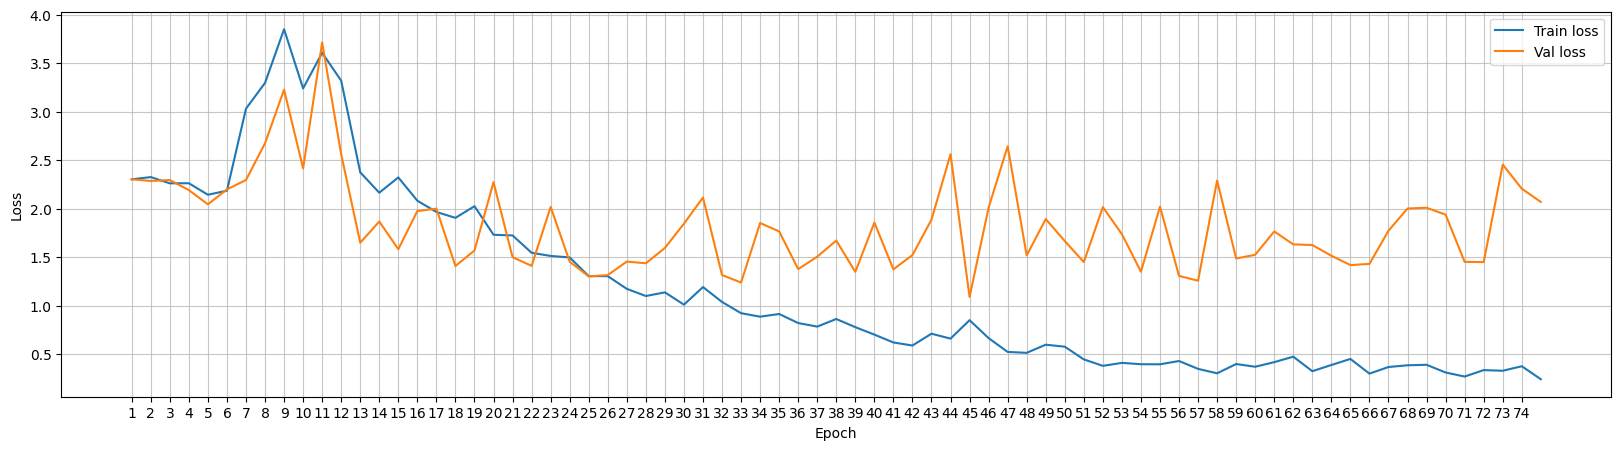

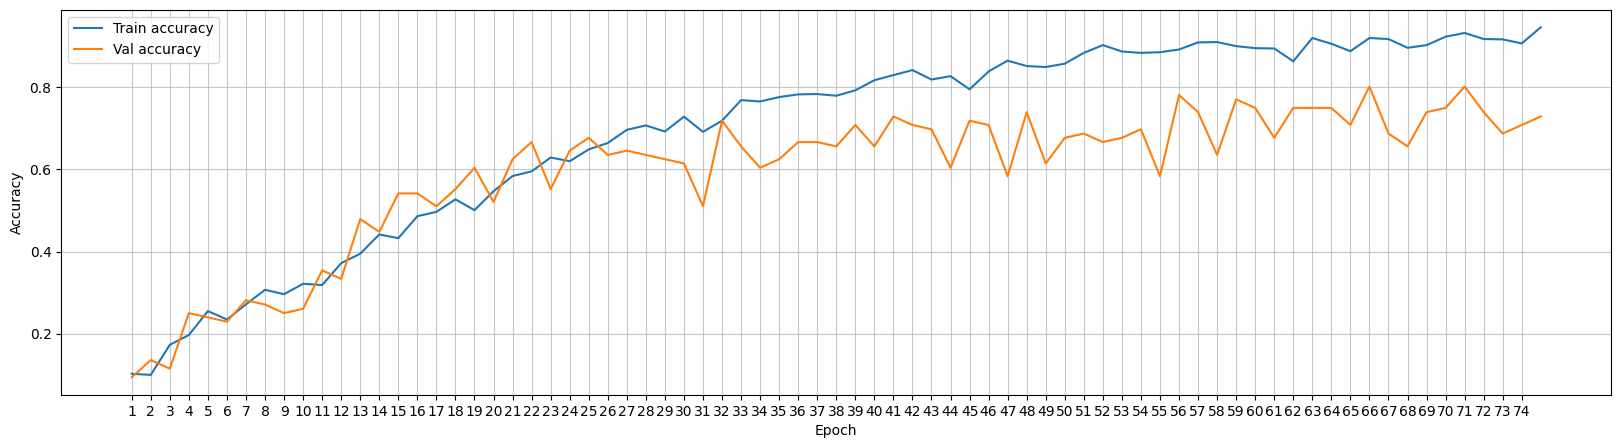

In [54]:
# Plot loss
plt.figure(figsize=(20,5))
plt.plot(np.arange(1, len(train_loss)+1), train_loss, label='Train loss')
plt.plot(np.arange(1, len(train_loss)+1), val_loss, label='Val loss')
plt.xticks(np.arange(1, len(train_loss)))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(alpha=.7)
plt.legend()

# Plot accuracy
plt.figure(figsize=(20,5))
plt.plot(np.arange(1, len(train_acc)+1), train_acc, label='Train accuracy')
plt.plot(np.arange(1, len(train_acc)+1), val_acc, label='Val accuracy')
plt.xticks(np.arange(1, len(train_acc)))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(alpha=.7)
plt.legend()
plt.show()

COMPREHENSIVE EVALUATION RESULTS
Accuracy: 0.7125 (71.25%)

MACRO AVERAGES:
  F1-Score   : 0.7021
  Precision  : 0.7553
  Recall     : 0.7125

WEIGHTED AVERAGES:
  F1-Score   : 0.7021
  Precision  : 0.7553
  Recall     : 0.7125

PER-CLASS METRICS:
------------------------------------------------------------
Class           F1       Precision  Recall  
------------------------------------------------------------
chainsaw        0.6667   0.7143     0.6250  
clock_tick      0.4000   1.0000     0.2500  
crackling_fire  0.9412   0.8889     1.0000  
crying_baby     1.0000   1.0000     1.0000  
dog             0.6000   0.5000     0.7500  
helicopter      0.7143   0.8333     0.6250  
rain            0.6000   0.5000     0.7500  
rooster         0.7500   0.7500     0.7500  
sea_waves       0.5714   0.6667     0.5000  
sneezing        0.7778   0.7000     0.8750  

DETAILED CLASSIFICATION REPORT
                precision    recall  f1-score   support

      chainsaw     0.7143    0.6250    0.6667 

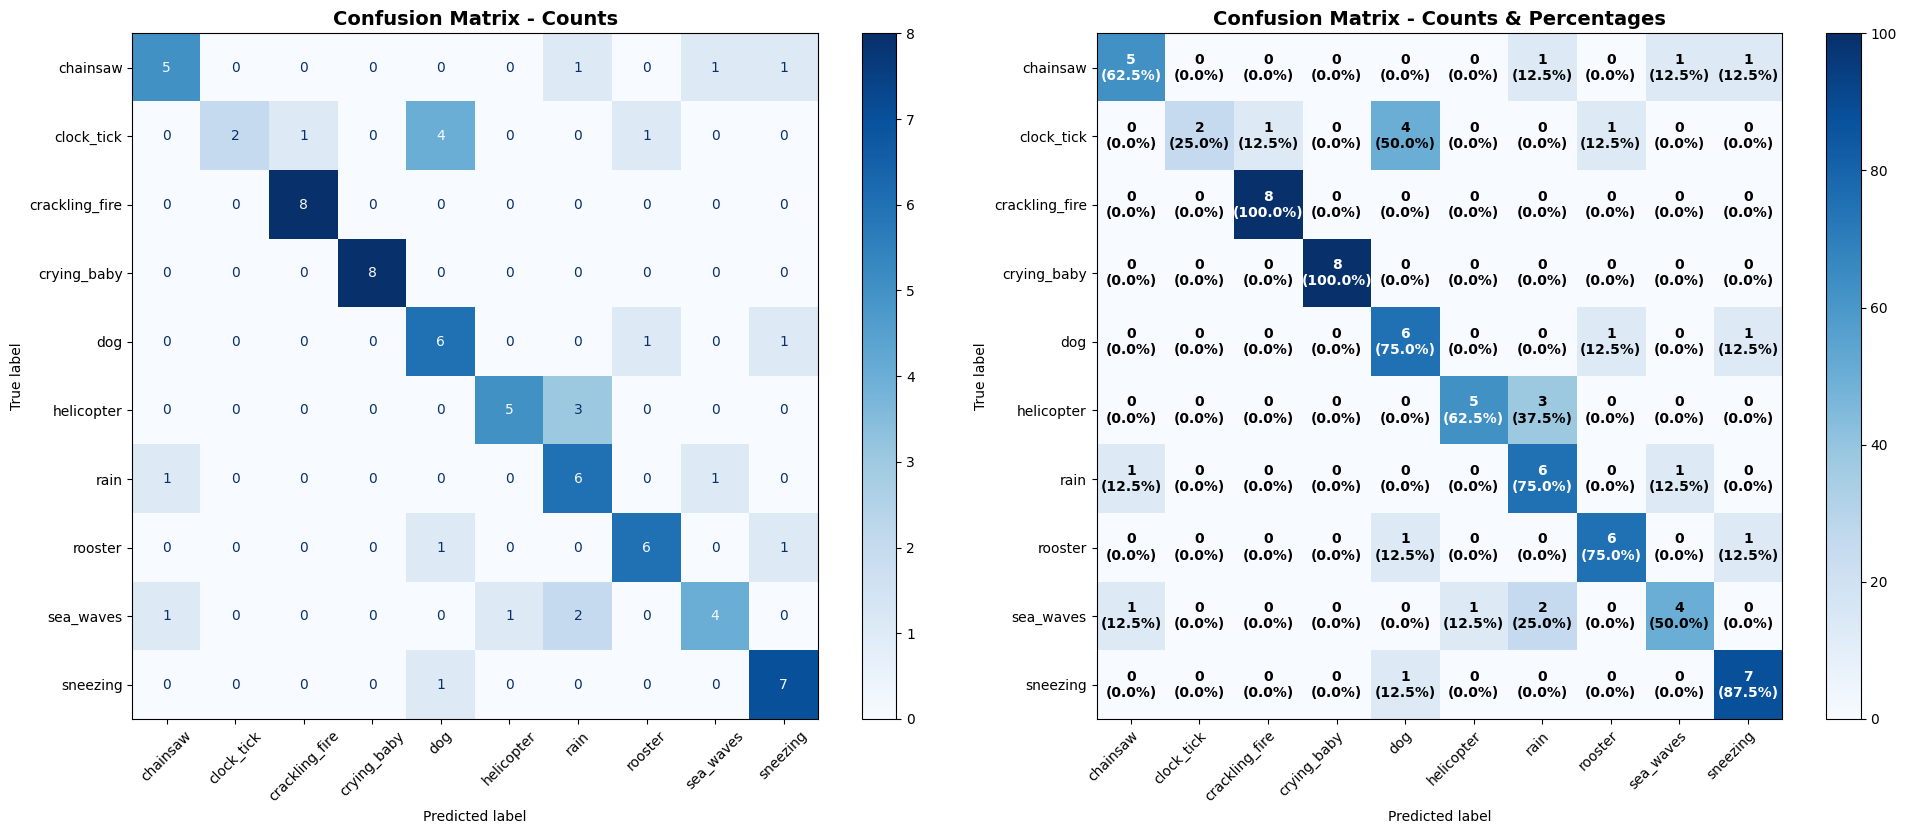


PER-CLASS ACCURACY BREAKDOWN
True Class      Correct  Total    Accuracy  
------------------------------------------------------------
chainsaw        5        8        62.50     %
clock_tick      2        8        25.00     %
crackling_fire  8        8        100.00    %
crying_baby     8        8        100.00    %
dog             6        8        75.00     %
helicopter      5        8        62.50     %
rain            6        8        75.00     %
rooster         6        8        75.00     %
sea_waves       4        8        50.00     %
sneezing        7        8        87.50     %


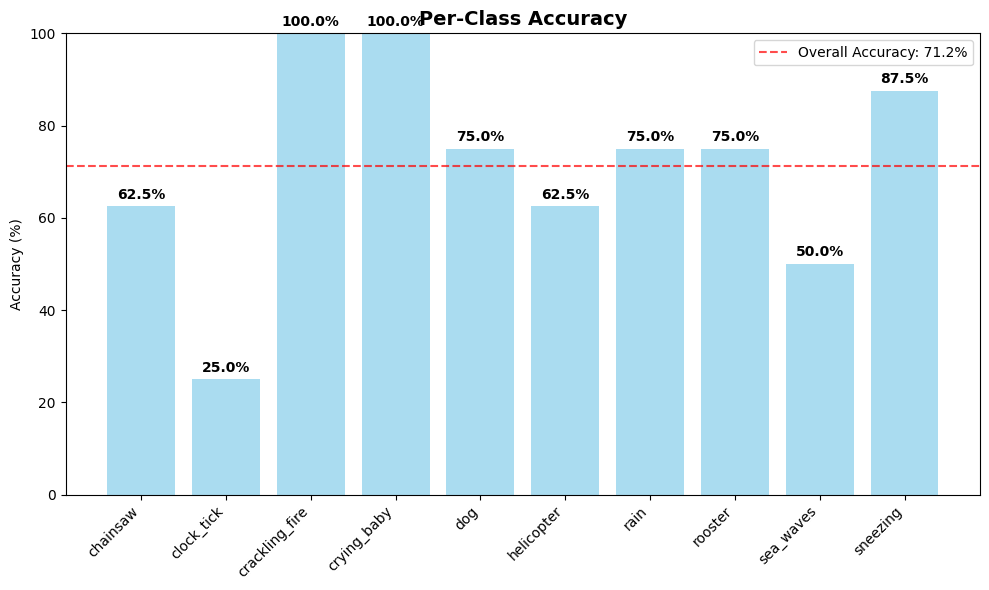

In [55]:
class_names = [
    'chainsaw', 'clock_tick', 'crackling_fire', 'crying_baby', 'dog',
    'helicopter', 'rain', 'rooster', 'sea_waves', 'sneezing'
]

results = evaluate_model_comprehensive(snn_classifier, sf_val_dataloader, class_names, device)

## Convolutional SNN (C-SNN)

In [42]:
class C_SNN(torch.nn.Module):
    def __init__(
        self,
        surr_grad,
        n_mels: int = 128,
        num_classes: int = 10,
        conv_channels1: int = 32,
        conv_channels2: int = 64,
        kernel_size: int = 3,
        pool_kernel: int = 2,
        dropout_rate: float = 0.15
    ):
        super().__init__()
        self.surr_grad = surr_grad

        # --- First Spiking Convolutional Block ---
        self.conv1 = torch.nn.Conv1d(
            in_channels=1,
            out_channels=conv_channels1,
            kernel_size=kernel_size,
            padding=kernel_size // 2,
            bias=False,
        )
        self.lif1 = snn.Leaky(
            beta=0.9,
            threshold=1.0,
            learn_beta=True,
            learn_threshold=True,
            spike_grad=surr_grad
        )
        self.pool1 = torch.nn.MaxPool1d(kernel_size=pool_kernel)

        # --- Second Spiking Convolutional Block ---
        self.conv2 = torch.nn.Conv1d(
            in_channels=conv_channels1,
            out_channels=conv_channels2,
            kernel_size=kernel_size,
            padding=kernel_size // 2,
            bias=False,
        )
        self.lif2 = snn.Leaky(
            beta=0.9,
            threshold=1.0,
            learn_beta=True,
            learn_threshold=True,
            spike_grad=surr_grad
        )
        self.pool2 = torch.nn.MaxPool1d(kernel_size=pool_kernel)

        # --- Fully Connected Layer ---
        freq_after_pool = n_mels // (pool_kernel * pool_kernel)  # because we pool twice
        self.flattened_size = conv_channels2 * freq_after_pool

        self.dropout = torch.nn.Dropout(p=dropout_rate)
        self.fc1 = torch.nn.Linear(self.flattened_size, num_classes, bias=False)
        self.lif_out = snn.Leaky(
            beta=0.9,
            threshold=1.0,
            learn_beta=True,
            learn_threshold=True,
            spike_grad=surr_grad
        )

    def forward(self, spikes: torch.Tensor):
        """
        spikes: [batch_size, time_steps, n_mels]
        Returns:
            spk_rec: [time_steps, batch_size, num_classes]
            mem_rec: [time_steps, batch_size, num_classes]
        """
        B, T, F = spikes.shape

        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem_out = self.lif_out.init_leaky()

        spk_rec = []
        mem_rec = []

        spikes_tm = spikes.permute(1, 0, 2)  # [T, B, F]

        for t in range(T):
            x_t = spikes_tm[t].unsqueeze(1)  # [B, 1, F]

            # --- Conv Block 1 ---
            x = self.conv1(x_t)
            spk1, mem1 = self.lif1(x, mem1)
            x = self.pool1(spk1)

            # --- Conv Block 2 ---
            x = self.conv2(x)
            spk2, mem2 = self.lif2(x, mem2)
            x = self.pool2(spk2)

            # --- Flatten + FC ---
            x = x.view(B, -1)
            x = self.dropout(x)
            x = self.fc1(x)
            spk_out, mem_out = self.lif_out(x, mem_out)

            spk_rec.append(spk_out)
            mem_rec.append(mem_out)

        spk_rec = torch.stack(spk_rec, dim=0)
        mem_rec = torch.stack(mem_rec, dim=0)

        return spk_rec, mem_rec


In [43]:
c_snn_model = C_SNN(
    surr_grad=snn.surrogate.fast_sigmoid(),
    n_mels=N_MELS,
    num_classes=10,
    conv_channels1=16,
    conv_channels2=32,
    kernel_size=3,
    pool_kernel=2
).to(device)


summary(c_snn_model, input_size=(32, 1, N_MELS))

Layer (type:depth-idx)                   Output Shape              Param #
C_SNN                                    [1, 32, 10]               --
├─Conv1d: 1-1                            [32, 16, 128]             48
├─Leaky: 1-2                             [32, 16, 128]             2
├─MaxPool1d: 1-3                         [32, 16, 64]              --
├─Conv1d: 1-4                            [32, 32, 64]              1,536
├─Leaky: 1-5                             [32, 32, 64]              2
├─MaxPool1d: 1-6                         [32, 32, 32]              --
├─Dropout: 1-7                           [32, 1024]                --
├─Linear: 1-8                            [32, 10]                  10,240
├─Leaky: 1-9                             [32, 10]                  2
Total params: 11,830
Trainable params: 11,830
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 3.67
Input size (MB): 0.02
Forward/backward pass size (MB): 2.10
Params size (MB): 0.05
Estimated Total Size (MB): 2

## CSNN Training

In [44]:
patience = 30
num_epochs = 100
optimizer = torch.optim.Adam(c_snn_model.parameters(), lr=0.0001)

train_loss, train_acc, val_loss, val_acc = train_fn(
    model=c_snn_model,
    train_loader=sf_train_dataloader,
    valid_loader=sf_val_dataloader,
    accuracy=SF.acc.accuracy_rate,
    loss_fn=snn.functional.ce_count_loss(),
    optimizer=optimizer,
    epochs=num_epochs,
    patience=patience,
    path="./",
    verbose=True,
)

Epochs:   1%|          | 1/100 [03:40<6:03:08, 220.09s/it]


Epoch 1/100 - 220s - loss: 2.3921 - acc: 0.1225 - val_loss: 2.3022 - val_acc: 0.1146



Epochs:   2%|▏         | 2/100 [08:10<6:47:53, 249.73s/it]


Epoch 2/100 - 270s - loss: 2.2756 - acc: 0.1456 - val_loss: 2.2008 - val_acc: 0.1562



Epochs:   3%|▎         | 3/100 [11:52<6:23:00, 236.91s/it]


Epoch 3/100 - 221s - loss: 2.1800 - acc: 0.1941 - val_loss: 2.1195 - val_acc: 0.2188



Epochs:   4%|▍         | 4/100 [15:33<6:09:19, 230.82s/it]


Epoch 4/100 - 221s - loss: 1.8681 - acc: 0.3092 - val_loss: 1.6855 - val_acc: 0.3958



Epochs:   5%|▌         | 5/100 [19:15<6:00:13, 227.51s/it]


Epoch 5/100 - 221s - loss: 1.5637 - acc: 0.4441 - val_loss: 1.3355 - val_acc: 0.4896



Epochs:   6%|▌         | 6/100 [22:54<5:52:04, 224.73s/it]


Epoch 6/100 - 219s - loss: 1.3654 - acc: 0.5016 - val_loss: 1.3230 - val_acc: 0.5000



Epochs:   7%|▋         | 7/100 [26:33<5:45:08, 222.68s/it]


Epoch 7/100 - 218s - loss: 1.2464 - acc: 0.5452 - val_loss: 1.1811 - val_acc: 0.5833



Epochs:   8%|▊         | 8/100 [30:11<5:39:20, 221.31s/it]


Epoch 8/100 - 218s - loss: 1.1371 - acc: 0.5740 - val_loss: 1.2359 - val_acc: 0.6042



Epochs:   9%|▉         | 9/100 [33:50<5:34:38, 220.64s/it]


Epoch 9/100 - 219s - loss: 1.0750 - acc: 0.6012 - val_loss: 1.2118 - val_acc: 0.5833



Epochs:  10%|█         | 10/100 [37:33<5:31:46, 221.18s/it]


Epoch 10/100 - 222s - loss: 1.0376 - acc: 0.6143 - val_loss: 1.1112 - val_acc: 0.6042



Epochs:  11%|█         | 11/100 [41:19<5:30:23, 222.73s/it]


Epoch 11/100 - 226s - loss: 0.9420 - acc: 0.6431 - val_loss: 1.2175 - val_acc: 0.6562



Epochs:  12%|█▏        | 12/100 [44:59<5:25:32, 221.96s/it]


Epoch 12/100 - 220s - loss: 0.9639 - acc: 0.6587 - val_loss: 1.1723 - val_acc: 0.5938



Epochs:  13%|█▎        | 13/100 [48:36<5:19:40, 220.47s/it]


Epoch 13/100 - 217s - loss: 0.8819 - acc: 0.6719 - val_loss: 1.1062 - val_acc: 0.6042



Epochs:  14%|█▍        | 14/100 [52:14<5:14:42, 219.57s/it]


Epoch 14/100 - 217s - loss: 0.8429 - acc: 0.6768 - val_loss: 1.2298 - val_acc: 0.5938



Epochs:  15%|█▌        | 15/100 [55:55<5:11:40, 220.00s/it]


Epoch 15/100 - 220s - loss: 0.7950 - acc: 0.7031 - val_loss: 1.1700 - val_acc: 0.6458



Epochs:  16%|█▌        | 16/100 [59:34<5:07:44, 219.81s/it]


Epoch 16/100 - 219s - loss: 0.7873 - acc: 0.6998 - val_loss: 1.1957 - val_acc: 0.6146



Epochs:  17%|█▋        | 17/100 [1:03:14<5:04:04, 219.81s/it]


Epoch 17/100 - 219s - loss: 0.7357 - acc: 0.7336 - val_loss: 1.0769 - val_acc: 0.5938



Epochs:  18%|█▊        | 18/100 [1:06:56<5:01:21, 220.51s/it]


Epoch 18/100 - 222s - loss: 0.7138 - acc: 0.7311 - val_loss: 1.0846 - val_acc: 0.6354



Epochs:  19%|█▉        | 19/100 [1:10:35<4:57:16, 220.21s/it]


Epoch 19/100 - 219s - loss: 0.6816 - acc: 0.7377 - val_loss: 1.1442 - val_acc: 0.6354



Epochs:  20%|██        | 20/100 [1:14:15<4:53:21, 220.02s/it]


Epoch 20/100 - 219s - loss: 0.6430 - acc: 0.7656 - val_loss: 1.1398 - val_acc: 0.6771



Epochs:  21%|██        | 21/100 [1:17:53<4:48:57, 219.47s/it]


Epoch 21/100 - 218s - loss: 0.6154 - acc: 0.7673 - val_loss: 1.1387 - val_acc: 0.6875



Epochs:  22%|██▏       | 22/100 [1:21:31<4:44:42, 219.00s/it]


Epoch 22/100 - 217s - loss: 0.6174 - acc: 0.7755 - val_loss: 1.0223 - val_acc: 0.7188



Epochs:  23%|██▎       | 23/100 [1:25:08<4:40:17, 218.40s/it]


Epoch 23/100 - 216s - loss: 0.6033 - acc: 0.7887 - val_loss: 1.1939 - val_acc: 0.7083



Epochs:  24%|██▍       | 24/100 [1:28:51<4:38:26, 219.83s/it]


Epoch 24/100 - 223s - loss: 0.5576 - acc: 0.8109 - val_loss: 1.1507 - val_acc: 0.7083



Epochs:  25%|██▌       | 25/100 [1:32:30<4:34:18, 219.45s/it]


Epoch 25/100 - 218s - loss: 0.5910 - acc: 0.7961 - val_loss: 1.1146 - val_acc: 0.7083



Epochs:  26%|██▌       | 26/100 [1:36:09<4:30:36, 219.42s/it]


Epoch 26/100 - 219s - loss: 0.5590 - acc: 0.8092 - val_loss: 1.0948 - val_acc: 0.7292



Epochs:  27%|██▋       | 27/100 [1:39:46<4:26:01, 218.65s/it]


Epoch 27/100 - 216s - loss: 0.5115 - acc: 0.8215 - val_loss: 1.1043 - val_acc: 0.7396



Epochs:  28%|██▊       | 28/100 [1:43:22<4:21:25, 217.86s/it]


Epoch 28/100 - 216s - loss: 0.5479 - acc: 0.8109 - val_loss: 1.1299 - val_acc: 0.6667



Epochs:  29%|██▉       | 29/100 [1:47:01<4:18:11, 218.20s/it]


Epoch 29/100 - 218s - loss: 0.5586 - acc: 0.8125 - val_loss: 0.9907 - val_acc: 0.7083



Epochs:  30%|███       | 30/100 [1:50:38<4:14:13, 217.90s/it]


Epoch 30/100 - 217s - loss: 0.5173 - acc: 0.8174 - val_loss: 1.0120 - val_acc: 0.6979



Epochs:  31%|███       | 31/100 [1:54:16<4:10:42, 218.01s/it]


Epoch 31/100 - 218s - loss: 0.5133 - acc: 0.8191 - val_loss: 0.9951 - val_acc: 0.7083



Epochs:  32%|███▏      | 32/100 [1:57:53<4:06:41, 217.66s/it]


Epoch 32/100 - 216s - loss: 0.5188 - acc: 0.8257 - val_loss: 1.1393 - val_acc: 0.7083



Epochs:  33%|███▎      | 33/100 [2:01:33<4:03:52, 218.40s/it]


Epoch 33/100 - 220s - loss: 0.4916 - acc: 0.8281 - val_loss: 1.1074 - val_acc: 0.7396



Epochs:  34%|███▍      | 34/100 [2:05:12<4:00:23, 218.54s/it]


Epoch 34/100 - 218s - loss: 0.4530 - acc: 0.8405 - val_loss: 1.0292 - val_acc: 0.7396



Epochs:  35%|███▌      | 35/100 [2:08:50<3:56:26, 218.26s/it]


Epoch 35/100 - 217s - loss: 0.4692 - acc: 0.8446 - val_loss: 0.9178 - val_acc: 0.7917



Epochs:  36%|███▌      | 36/100 [2:12:27<3:52:22, 217.85s/it]


Epoch 36/100 - 216s - loss: 0.4509 - acc: 0.8462 - val_loss: 1.0645 - val_acc: 0.7083



Epochs:  37%|███▋      | 37/100 [2:16:03<3:48:19, 217.44s/it]


Epoch 37/100 - 216s - loss: 0.4592 - acc: 0.8413 - val_loss: 1.1433 - val_acc: 0.7083



Epochs:  38%|███▊      | 38/100 [2:19:39<3:44:07, 216.89s/it]


Epoch 38/100 - 215s - loss: 0.4352 - acc: 0.8495 - val_loss: 1.0332 - val_acc: 0.7604



Epochs:  39%|███▉      | 39/100 [2:23:17<3:40:53, 217.28s/it]


Epoch 39/100 - 218s - loss: 0.4469 - acc: 0.8553 - val_loss: 0.9734 - val_acc: 0.7604



Epochs:  40%|████      | 40/100 [2:26:56<3:37:50, 217.85s/it]


Epoch 40/100 - 219s - loss: 0.4248 - acc: 0.8602 - val_loss: 1.0151 - val_acc: 0.7083



Epochs:  41%|████      | 41/100 [2:30:36<3:34:43, 218.36s/it]


Epoch 41/100 - 219s - loss: 0.4193 - acc: 0.8594 - val_loss: 1.0746 - val_acc: 0.7604



Epochs:  42%|████▏     | 42/100 [2:34:14<3:30:57, 218.24s/it]


Epoch 42/100 - 217s - loss: 0.4211 - acc: 0.8553 - val_loss: 1.0584 - val_acc: 0.7188



Epochs:  43%|████▎     | 43/100 [2:37:48<3:26:15, 217.11s/it]


Epoch 43/100 - 214s - loss: 0.4175 - acc: 0.8651 - val_loss: 1.0418 - val_acc: 0.7604



Epochs:  44%|████▍     | 44/100 [2:41:25<3:22:34, 217.04s/it]


Epoch 44/100 - 216s - loss: 0.4209 - acc: 0.8610 - val_loss: 1.0786 - val_acc: 0.7917



Epochs:  45%|████▌     | 45/100 [2:45:00<3:18:20, 216.38s/it]


Epoch 45/100 - 214s - loss: 0.3991 - acc: 0.8635 - val_loss: 0.9514 - val_acc: 0.8021



Epochs:  46%|████▌     | 46/100 [2:48:35<3:14:28, 216.07s/it]


Epoch 46/100 - 215s - loss: 0.3899 - acc: 0.8709 - val_loss: 0.9593 - val_acc: 0.7292



Epochs:  47%|████▋     | 47/100 [2:52:14<3:11:34, 216.88s/it]


Epoch 47/100 - 218s - loss: 0.3745 - acc: 0.8717 - val_loss: 1.1017 - val_acc: 0.7708



Epochs:  48%|████▊     | 48/100 [2:55:52<3:08:16, 217.23s/it]


Epoch 48/100 - 218s - loss: 0.3749 - acc: 0.8840 - val_loss: 0.9273 - val_acc: 0.7812



Epochs:  49%|████▉     | 49/100 [2:59:30<3:04:42, 217.31s/it]


Epoch 49/100 - 217s - loss: 0.3807 - acc: 0.8775 - val_loss: 0.9710 - val_acc: 0.8021



Epochs:  50%|█████     | 50/100 [3:03:05<3:00:37, 216.76s/it]


Epoch 50/100 - 215s - loss: 0.3617 - acc: 0.8742 - val_loss: 1.0178 - val_acc: 0.7708



Epochs:  51%|█████     | 51/100 [3:06:42<2:56:57, 216.69s/it]


Epoch 51/100 - 216s - loss: 0.3477 - acc: 0.8873 - val_loss: 1.0328 - val_acc: 0.7917



Epochs:  52%|█████▏    | 52/100 [3:10:17<2:53:09, 216.44s/it]


Epoch 52/100 - 215s - loss: 0.3377 - acc: 0.8972 - val_loss: 1.0352 - val_acc: 0.8229



Epochs:  53%|█████▎    | 53/100 [3:13:54<2:49:33, 216.45s/it]


Epoch 53/100 - 216s - loss: 0.3373 - acc: 0.8988 - val_loss: 1.0803 - val_acc: 0.7500



Epochs:  54%|█████▍    | 54/100 [3:17:30<2:45:44, 216.19s/it]


Epoch 54/100 - 215s - loss: 0.3285 - acc: 0.9005 - val_loss: 1.1293 - val_acc: 0.7708



Epochs:  55%|█████▌    | 55/100 [3:21:06<2:42:13, 216.30s/it]


Epoch 55/100 - 216s - loss: 0.3365 - acc: 0.8939 - val_loss: 1.1109 - val_acc: 0.7812



Epochs:  56%|█████▌    | 56/100 [3:24:43<2:38:40, 216.37s/it]


Epoch 56/100 - 216s - loss: 0.3466 - acc: 0.8882 - val_loss: 1.0880 - val_acc: 0.7812



Epochs:  57%|█████▋    | 57/100 [3:28:20<2:35:12, 216.57s/it]


Epoch 57/100 - 217s - loss: 0.3024 - acc: 0.9046 - val_loss: 1.0227 - val_acc: 0.8542



Epochs:  58%|█████▊    | 58/100 [3:31:57<2:31:42, 216.72s/it]


Epoch 58/100 - 217s - loss: 0.3043 - acc: 0.9062 - val_loss: 1.1273 - val_acc: 0.8333



Epochs:  59%|█████▉    | 59/100 [3:35:33<2:28:00, 216.60s/it]


Epoch 59/100 - 216s - loss: 0.2838 - acc: 0.9021 - val_loss: 1.0575 - val_acc: 0.7917



Epochs:  60%|██████    | 60/100 [3:39:10<2:24:33, 216.85s/it]


Epoch 60/100 - 217s - loss: 0.2962 - acc: 0.9062 - val_loss: 0.9847 - val_acc: 0.8438



Epochs:  61%|██████    | 61/100 [3:42:47<2:20:52, 216.73s/it]


Epoch 61/100 - 216s - loss: 0.2933 - acc: 0.9104 - val_loss: 0.9970 - val_acc: 0.8646



Epochs:  62%|██████▏   | 62/100 [3:46:23<2:17:09, 216.57s/it]


Epoch 62/100 - 216s - loss: 0.2495 - acc: 0.9227 - val_loss: 0.9695 - val_acc: 0.8750



Epochs:  63%|██████▎   | 63/100 [3:49:58<2:13:19, 216.20s/it]


Epoch 63/100 - 215s - loss: 0.2531 - acc: 0.9161 - val_loss: 0.9796 - val_acc: 0.8333



Epochs:  64%|██████▍   | 64/100 [3:53:33<2:09:28, 215.80s/it]


Epoch 64/100 - 214s - loss: 0.2480 - acc: 0.9235 - val_loss: 1.1003 - val_acc: 0.8125



Epochs:  64%|██████▍   | 64/100 [3:57:12<2:13:25, 222.38s/it]

Early stopping triggered


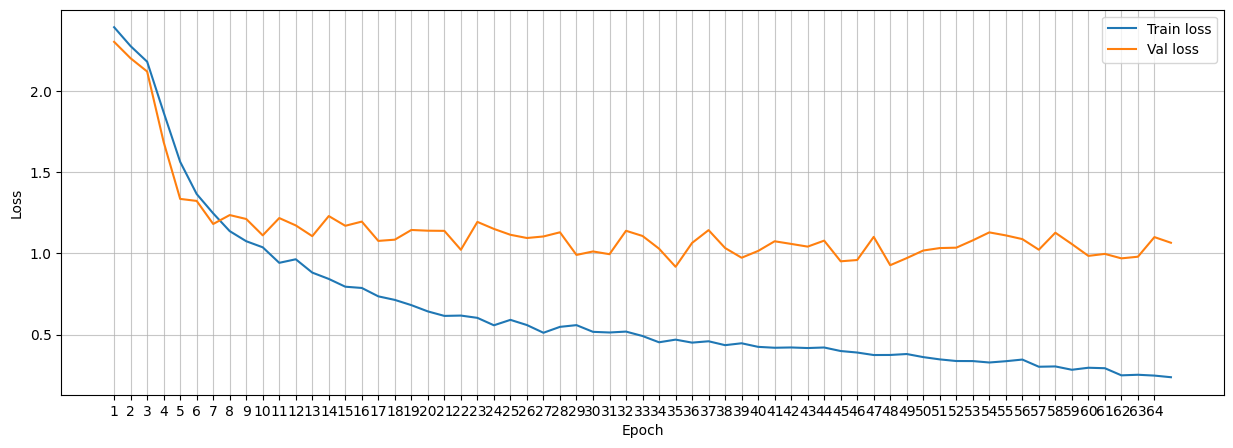

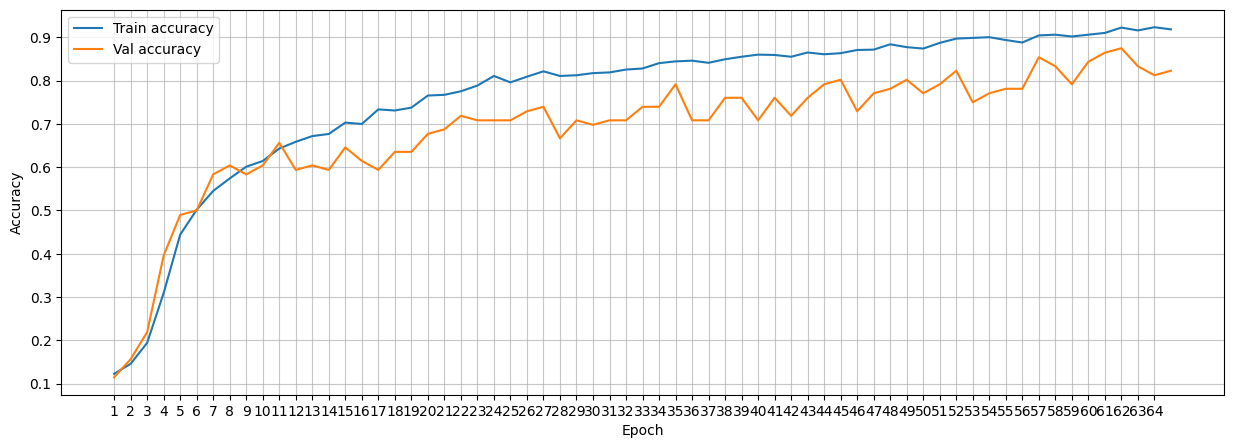

COMPREHENSIVE EVALUATION RESULTS
Accuracy: 0.7125 (71.25%)

MACRO AVERAGES:
  F1-Score   : 0.7188
  Precision  : 0.7523
  Recall     : 0.7125

WEIGHTED AVERAGES:
  F1-Score   : 0.7188
  Precision  : 0.7523
  Recall     : 0.7125

PER-CLASS METRICS:
------------------------------------------------------------
Class           F1       Precision  Recall  
------------------------------------------------------------
chainsaw        0.8571   1.0000     0.7500  
clock_tick      0.5882   0.5556     0.6250  
crackling_fire  0.6000   0.5000     0.7500  
crying_baby     1.0000   1.0000     1.0000  
dog             0.7143   0.8333     0.6250  
helicopter      0.6667   0.7143     0.6250  
rain            0.6667   0.5385     0.8750  
rooster         0.8571   1.0000     0.7500  
sea_waves       0.5714   0.6667     0.5000  
sneezing        0.6667   0.7143     0.6250  

DETAILED CLASSIFICATION REPORT
                precision    recall  f1-score   support

      chainsaw     1.0000    0.7500    0.8571 

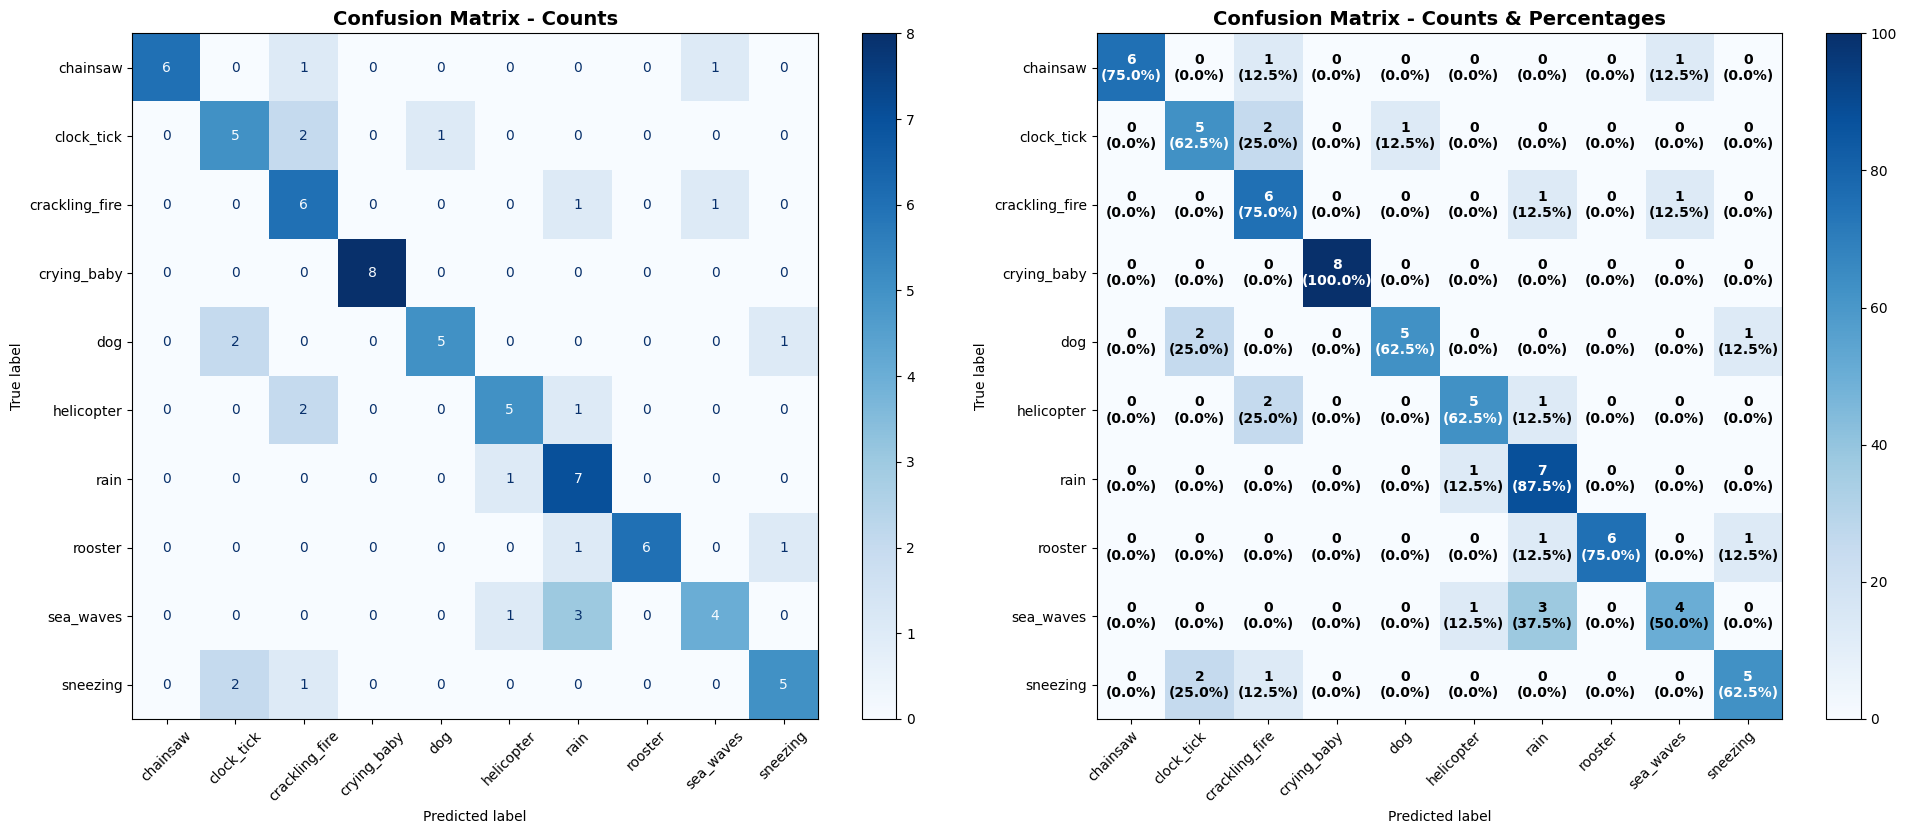


PER-CLASS ACCURACY BREAKDOWN
True Class      Correct  Total    Accuracy  
------------------------------------------------------------
chainsaw        6        8        75.00     %
clock_tick      5        8        62.50     %
crackling_fire  6        8        75.00     %
crying_baby     8        8        100.00    %
dog             5        8        62.50     %
helicopter      5        8        62.50     %
rain            7        8        87.50     %
rooster         6        8        75.00     %
sea_waves       4        8        50.00     %
sneezing        5        8        62.50     %


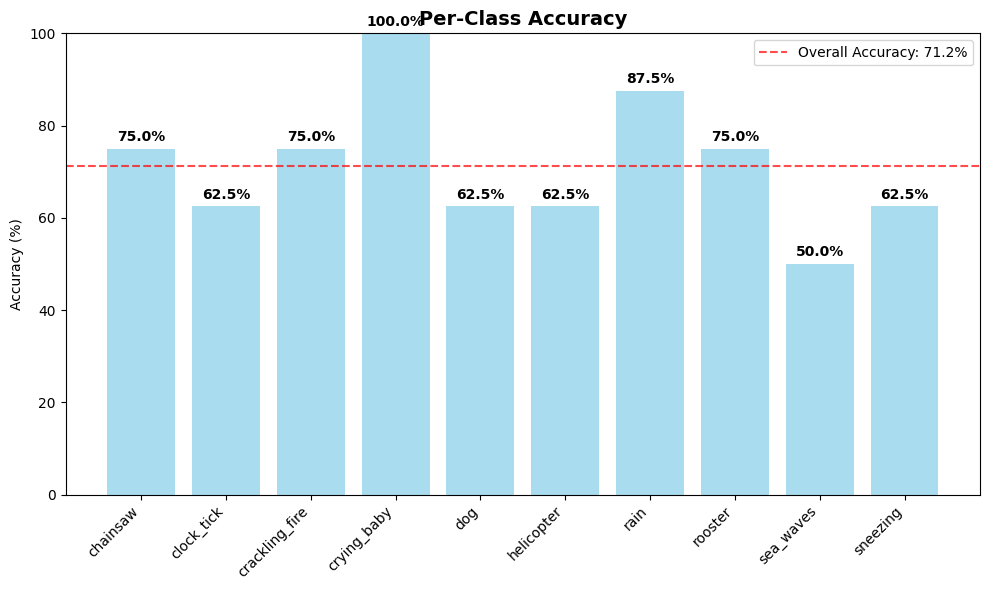

In [45]:
# Plot loss
plt.figure(figsize=(15,5))
plt.plot(np.arange(1, len(train_loss)+1), train_loss, label='Train loss')
plt.plot(np.arange(1, len(train_loss)+1), val_loss, label='Val loss')
plt.xticks(np.arange(1, len(train_loss)))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(alpha=.7)
plt.legend()

# Plot accuracy
plt.figure(figsize=(15,5))
plt.plot(np.arange(1, len(train_acc)+1), train_acc, label='Train accuracy')
plt.plot(np.arange(1, len(train_acc)+1), val_acc, label='Val accuracy')
plt.xticks(np.arange(1, len(train_acc)))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(alpha=.7)
plt.legend()
plt.show()

class_names = [
    'chainsaw', 'clock_tick', 'crackling_fire', 'crying_baby', 'dog',
    'helicopter', 'rain', 'rooster', 'sea_waves', 'sneezing'
]

results = evaluate_model_comprehensive(c_snn_model, sf_test_dataloader, class_names, device)